In [ ]:
print("Hello, World!")


Hello, World!


In [ ]:
import os
import time
import socket
import xarray as xr
import rioxarray
import numpy as np
import dask.array as da
from odc.stac import load as odc_load
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=8, threads_per_worker=1, memory_limit="30GB")


In [ ]:
def load_glance_local(stac_path: str, year: int, geobox, chunk_size=2048):
    """
    Load GLANCE items for a given year and align to the provided geobox.
    Returns a single xarray.DataArray (squeezed time dim).
    """
    import pystac
    cat = pystac.Catalog.from_file(stac_path)
    items = [it for it in cat.get_items(recursive=True)
             if getattr(it, "datetime", None) and it.datetime.year == year]
    if not items:
        raise RuntimeError(f"No GLANCE items found for year {year}")

    ds = odc_load(
        items,
        geobox=geobox,
        chunks={"x": chunk_size, "y": chunk_size},
        resampling="nearest",
        fail_on_error=False,
    )

    # choose first datavar unless you know exact name
    var = next(iter(ds.data_vars))
    gl = ds[var].squeeze(drop=True)

    # normalize dim names
    rename = {}
    if "latitude" in gl.dims:
        rename["latitude"] = "y"
    if "longitude" in gl.dims:
        rename["longitude"] = "x"
    if rename:
        gl = gl.rename(rename)

    return gl

# paths
year = 2016
chunk_size = 1024*4  # for both x and y
stac_path = "/projectnb/modislc/users/chishan/stac_glance_SA_fixed_m/catalog.json"
mb_path   = f"/projectnb/modislc/users/chishan/data/MapBiomas/COG/AMZ.{year}.M.cog.tif"

# load MapBiomas COG (chunks aligne)
mb = rioxarray.open_rasterio(mb_path, chunks={"y": chunk_size, "x": chunk_size}).squeeze(drop=True)
if "latitude" in mb.dims or "longitude" in mb.dims:
    mb = mb.rename({"latitude": "y", "longitude": "x"})
mb_nodata = mb.rio.nodata if mb.rio.nodata is not None else 0
print(f"‚úì MapBiomas loaded: shape={mb.shape}, dims={mb.dims}, CRS={mb.rio.crs}, nodata={mb_nodata}")
print(f"  Geobox: width={mb.odc.geobox.width}, height={mb.odc.geobox.height}, res={mb.odc.geobox.resolution}")

# # load GLANCE aligned to MapBiomas grid
# gl = load_glance_local(stac_path, year, geobox=mb.odc.geobox, chunk_size=chunk_size)
# gl_nodata = gl.rio.nodata if hasattr(gl, "rio") and (gl.rio.nodata is not None) else 255
# print(f"‚úì GLANCE loaded: shape={gl.shape}, dims={gl.dims}, nodata={gl_nodata}")


‚úì MapBiomas loaded: shape=(243684, 339821), dims=('y', 'x'), CRS=EPSG:4674, nodata=0
  Geobox: width=339821, height=243684, res=Resolution(x=9e-05, y=-9e-05)


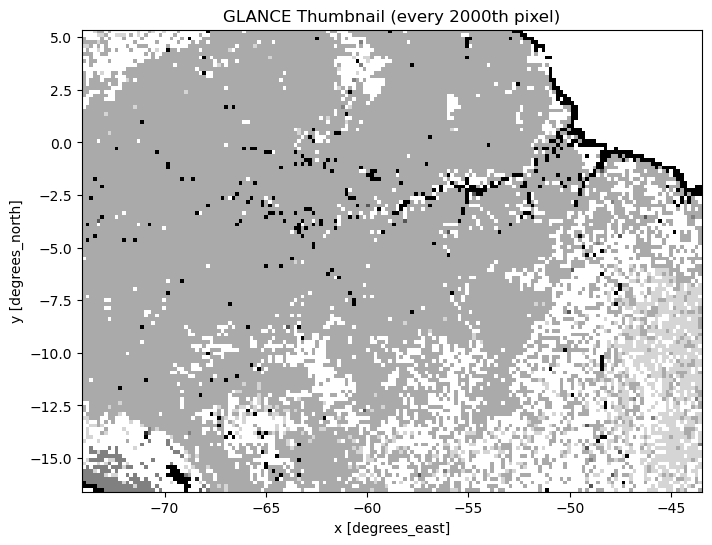

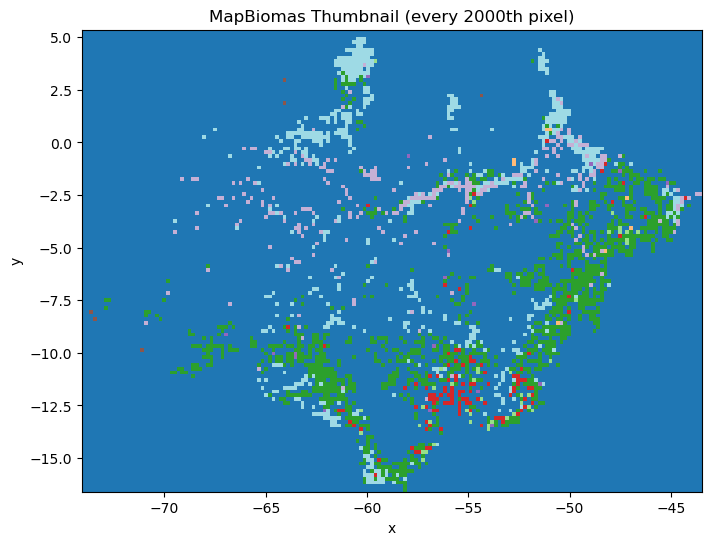

In [7]:
# Plot GLANCE and MapBiomas using xarray plotting (efficient for dask arrays)
import matplotlib.pyplot as plt

# Quick thumbnails: downsample by subsetting (much faster than coarsen)
# Use integer step size for direct indexing (no computation needed)
step = 2000

# 1) Plot GLANCE thumbnail (single-band grayscale) - simple slice, no compute
plt.figure(figsize=(8, 6))
try:
    gl[::step, ::step].plot.imshow(cmap='gray', add_colorbar=False)
    plt.title(f'GLANCE Thumbnail (every {step}th pixel)')
except NameError as _nerr:
    print('GLANCE (gl) not defined in this scope:', _nerr)
plt.show()

# 2) Plot MapBiomas thumbnail - slice directly, compute only when plotting
plt.figure(figsize=(8, 6))
try:
    # For categorical data, use mode (most common) instead of mean, or just slice
    # Direct slicing is fastest and preserves categorical values
    mb[::step, ::step].plot.imshow(cmap='tab20', add_colorbar=False, vmin=0, vmax=50)
    plt.title(f'MapBiomas Thumbnail (every {step}th pixel)')
except NameError as _nerr:
    print('MapBiomas (mb) not defined in this scope:', _nerr)
plt.show()

# Notes: Direct slicing [::step, ::step] is fastest - dask computes only selected pixels during plot.
# No need for .coarsen().mean().compute() which computes ALL pixels then averages.


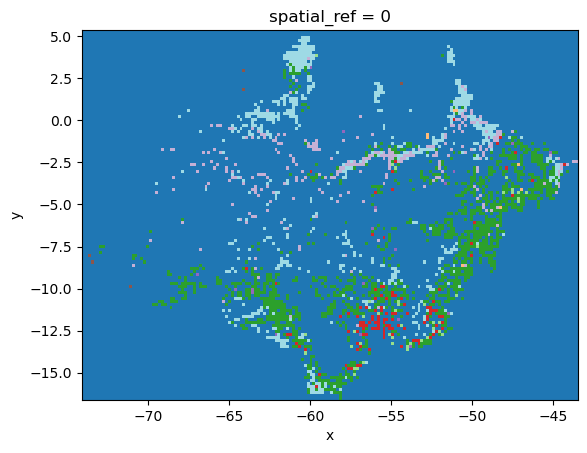

In [9]:
mb_thumb = mb.isel(y=slice(None, None, step), x=slice(None, None, step))
mb_thumb.plot.imshow(cmap="tab20", add_colorbar=False, vmin=1, vmax=54)


In [12]:
mb.rio.nodata


np.uint8(0)

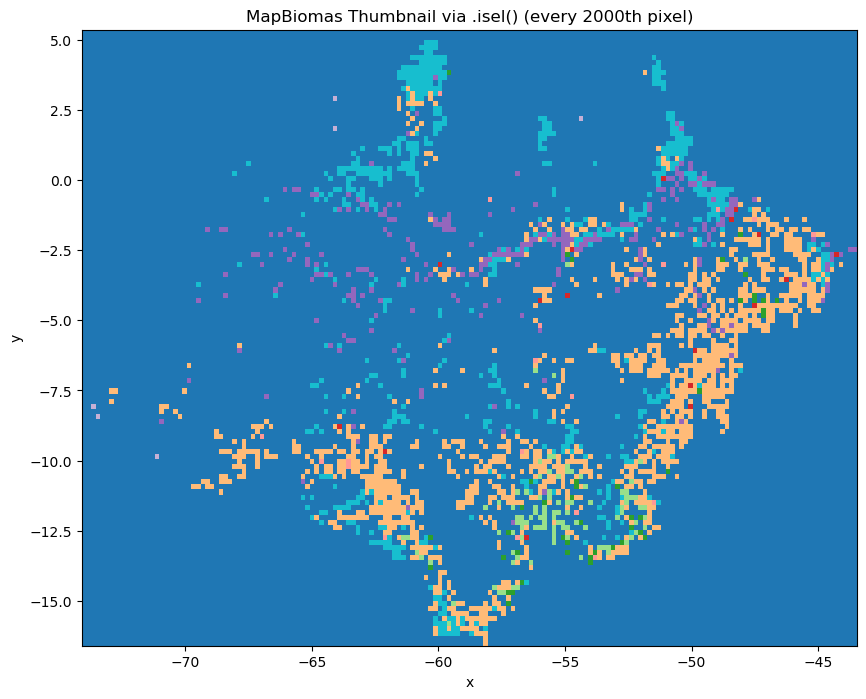

In [10]:
# Alternative: use .isel() with explicit dimension names (more readable)
import matplotlib.pyplot as plt

step = 2000

plt.figure(figsize=(10, 8))

# Method 1: Direct slicing mb[::step, ::step]
# Method 2: .isel() with named dimensions (clearer for multi-dim data)
mb_thumb = mb.isel(y=slice(None, None, step), x=slice(None, None, step))

mb_thumb.plot.imshow(cmap="tab20", add_colorbar=False, vmin=1, vmax=54)
plt.title(f'MapBiomas Thumbnail via .isel() (every {step}th pixel)')
plt.show()

# Notes: 
# - .isel() is more explicit: isel(y=slice(None, None, step)) == [::step] for y dimension
# - Useful when you have multiple dimensions and want to be clear which you're slicing
# - Performance is identical to direct slicing [::step, ::step]


In [ ]:
from scipy.stats import mode

mb_thumb = mb.coarsen(y=step, x=step, boundary='trim').reduce(
    lambda arr, axis: mode(arr, axis=-1, keepdims=False).mode
)
mb_thumb.plot.imshow(cmap="tab20", add_colorbar=False, vmin=1, vmax=54)


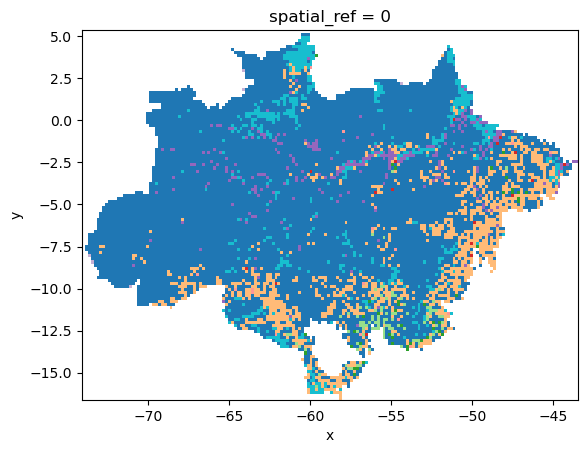

In [21]:
nodata = mb.rio.nodata  # Â¶ÇÊûúËøòÊ≤°ÂÜôÔºåÂÖà mb = mb.rio.write_nodata(0)
mb_thumb = mb.isel(y=slice(None, None, step), x=slice(None, None, step))
mb_thumb = mb_thumb.where(mb_thumb != nodata)  # Êàñ .where(~np.isclose(...))

cmap = plt.get_cmap("tab20").copy()
cmap.set_bad(color="none", alpha=0)

mb_thumb.plot.imshow(cmap=cmap, add_colorbar=False, vmin=1, vmax=54)


In [22]:
gl.rio.nodata


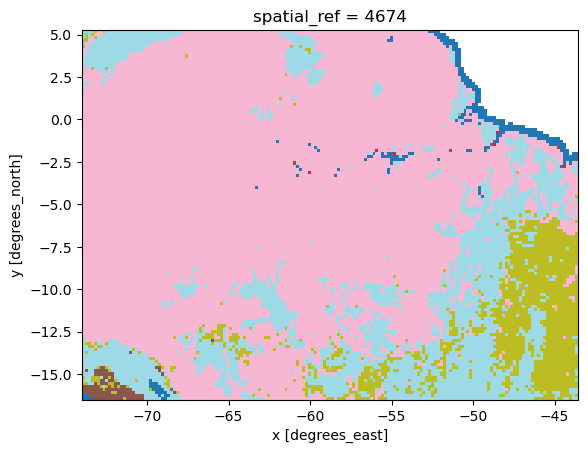

In [24]:
nodata = 255
gl_thumb = gl.coarsen(y=step, x=step, boundary='trim').median()
gl_thumb = gl_thumb.where(gl_thumb != nodata)

cmap = plt.get_cmap("tab20").copy()
cmap.set_bad(color="none", alpha=0)

gl_thumb.plot.imshow(cmap=cmap, add_colorbar=False, vmin=1, vmax=7)


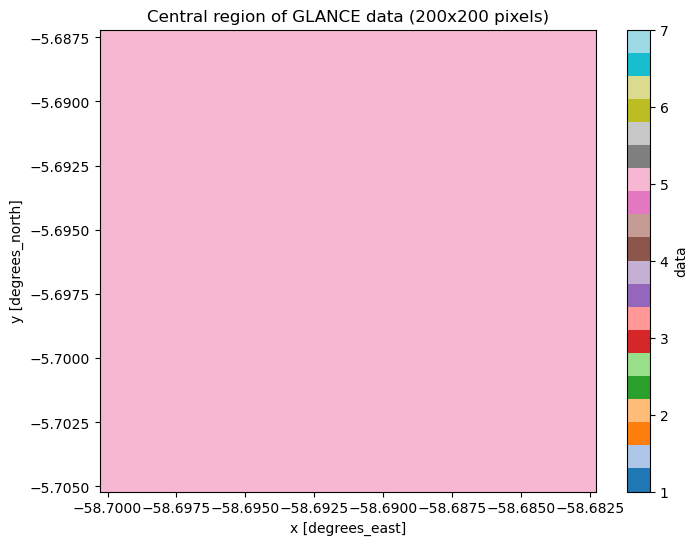

In [25]:
# Select a small central region of gl and plot
import matplotlib.pyplot as plt

# Get the center indices
center_y = gl.sizes['y'] // 2
center_x = gl.sizes['x'] // 2

# Define the size of the small region (e.g., 200x200 pixels)
size = 200
start_y = max(0, center_y - size // 2)
end_y = min(gl.sizes['y'], center_y + size // 2)
start_x = max(0, center_x - size // 2)
end_x = min(gl.sizes['x'], center_x + size // 2)

# Select the central region
gl_center = gl.isel(y=slice(start_y, end_y), x=slice(start_x, end_x))

# Plot the central region
plt.figure(figsize=(8, 6))
gl_center.plot.imshow(cmap='tab20', vmin=1, vmax=7)
plt.title(f'Central region of GLANCE data ({size}x{size} pixels)')
plt.show()


GLANCE coordinates:
Coordinates:
  * y            (y) float64 2MB 5.27 5.269 5.269 5.269 ... -16.66 -16.66 -16.66
  * x            (x) float64 3MB -73.98 -73.98 -73.98 ... -43.4 -43.4 -43.4
    spatial_ref  int32 4B 4674
GLANCE y (latitude) range: -16.66 to 5.27
GLANCE x (longitude) range: -73.98 to -43.40
Selected region shape: (27777, 55555)
Thumbnail shape: (2777, 5555)


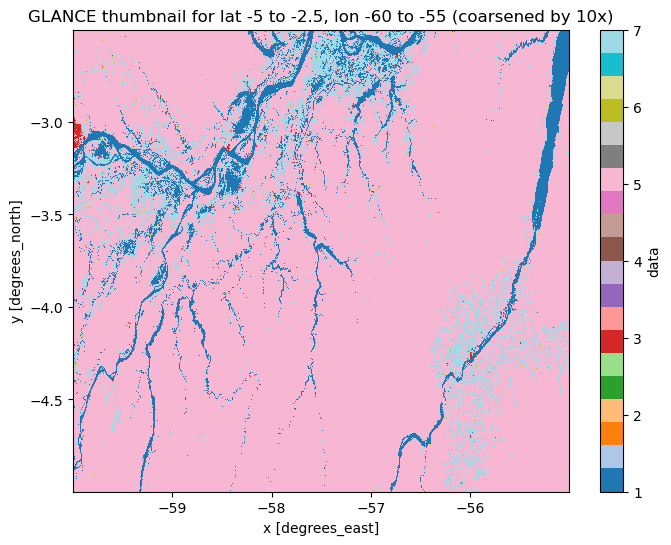

In [3]:
# Select region by latitude and longitude coordinates
import matplotlib.pyplot as plt

# Check the coordinates
print("GLANCE coordinates:")
print(gl.coords)
print(f"GLANCE y (latitude) range: {gl.y.min().values:.2f} to {gl.y.max().values:.2f}")
print(f"GLANCE x (longitude) range: {gl.x.min().values:.2f} to {gl.x.max().values:.2f}")

# Define the latitude (y) and longitude (x) ranges
lat_min, lat_max = -5, -2.5
lon_min, lon_max = -60, -55

# Since y coordinates are decreasing (from north to south), slice from higher to lower lat
# For x, coordinates are increasing (west to east)
gl_region = gl.sel(y=slice(lat_max, lat_min), x=slice(lon_min, lon_max))

print(f"Selected region shape: {gl_region.shape}")

# Since the region is large, create a thumbnail by coarsening
step = 10  # coarsen by factor of 100
gl_thumb = gl_region.coarsen(y=step, x=step, boundary='trim').median()

print(f"Thumbnail shape: {gl_thumb.shape}")

# Plot the thumbnail
plt.figure(figsize=(8, 6))
gl_thumb.plot.imshow(cmap='tab20', vmin=1, vmax=7)
plt.title(f'GLANCE thumbnail for lat {lat_min} to {lat_max}, lon {lon_min} to {lon_max} (coarsened by {step}x)')
plt.show()


Map extent: lat [-16.66, 5.27], lon [-73.98, -43.40]
Map center: lat -5.70, lon -58.69
COG path: /projectnb/modislc/users/chishan/data/MapBiomas/COG/AMZ.2016.M.cog.tif

‚è≥ Inspecting COG structure...
  ‚úì CRS: EPSG:4674
  ‚úì Shape: (243684, 339821)
  ‚úì Bounds: BoundingBox(left=-73.98318216, bottom=-16.661979170000002, right=-43.39929216, top=5.26958083)
  ‚úì Data type: uint8
  ‚úì Overviews available: [2, 4, 8, 16, 32, 64, 128, 256, 513, 1027]
  ‚úì Block size: (512, 512)

‚è≥ Creating adaptive MapBiomas overlay from COG...
  Using overview level: 513
  ‚ö†Ô∏è  Using fallback method: Cannot open overview level 513 of /projectnb/modislc/users/chishan/data/MapBiomas/COG/AMZ.2016.M.cog.tif
  ‚úì Raster overlay created (base64 size: 30770 chars)
  ‚úì Added selected region: lat [-5.00, -2.50], lon [-60.00, -55.00]

‚úì Interactive map created with Folium (COG-aware)
  Features:
    - MapBiomas raster from COG with adaptive resolution
    - Red boundary: Full MapBiomas extent
    - Bl


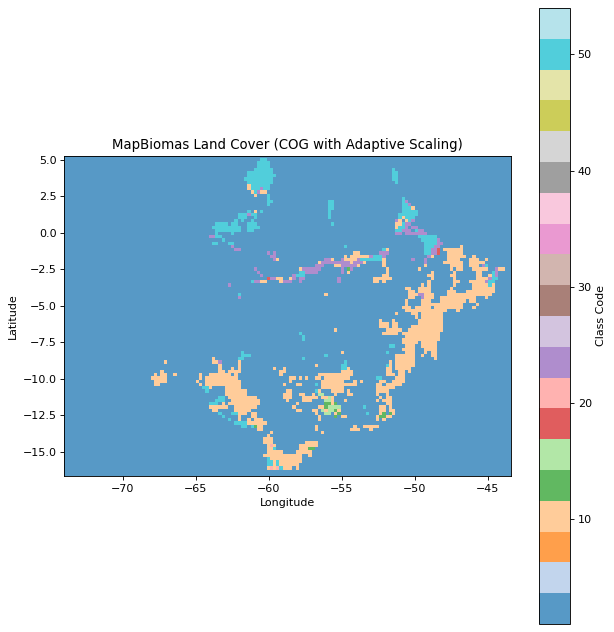

In [20]:
# Interactive map with COG dynamic scaling using rasterio (FIXED v2)
# This reads different resolution levels of the COG based on map zoom level
import folium
from folium import plugins
import numpy as np
import base64
import io
import matplotlib.pyplot as plt
import rasterio
from rasterio.vrt import WarpedVRT
from rasterio.enums import Resampling

# Define COG path and map extent
cog_path = f"/projectnb/modislc/users/chishan/data/MapBiomas/COG/AMZ.{year}.M.cog.tif"

# Calculate map center and bounds from MapBiomas data
# CRITICAL: Convert all to Python float to avoid JSON serialization errors
lat_center = float((mb.y.min().values + mb.y.max().values) / 2)
lon_center = float((mb.x.min().values + mb.x.max().values) / 2)
lat_min_map = float(mb.y.min().values)
lat_max_map = float(mb.y.max().values)
lon_min_map = float(mb.x.min().values)
lon_max_map = float(mb.x.max().values)

print(f"Map extent: lat [{lat_min_map:.2f}, {lat_max_map:.2f}], lon [{lon_min_map:.2f}, {lon_max_map:.2f}]")
print(f"Map center: lat {lat_center:.2f}, lon {lon_center:.2f}")
print(f"COG path: {cog_path}")

# Inspect COG structure using rasterio
print("\n‚è≥ Inspecting COG structure...")
try:
    with rasterio.open(cog_path) as src:
        print(f"  ‚úì CRS: {src.crs}")
        print(f"  ‚úì Shape: {src.shape}")
        print(f"  ‚úì Bounds: {src.bounds}")
        print(f"  ‚úì Data type: {src.dtypes[0]}")
        overviews = src.overviews(1)
        print(f"  ‚úì Overviews available: {overviews}")
        print(f"  ‚úì Block size: {src.block_shapes[0]}")
except Exception as e:
    print(f"  ‚ö†Ô∏è  Error reading COG: {e}")

# Create base folium map
m = folium.Map(
    location=[lat_center, lon_center],
    zoom_start=6,
    tiles='OpenStreetMap'
)

# === Strategy: Use COG with dynamic resolution ===
# Read different overview levels based on zoom to get adaptive detail

print("\n‚è≥ Creating adaptive MapBiomas overlay from COG...")

# Read full resolution for initial overlay (use overview if available)
try:
    with rasterio.open(cog_path) as src:
        # Get the best overview for initial display (zoom level 6 ~ 100km detail)
        # Calculate approximate pixels needed for web display
        target_pixels = 200  # balance between detail and speed
        
        # Determine which overview to use
        available_overviews = [1] + src.overviews(1)
        print(f"  Available overviews: {available_overviews}")
        
        if available_overviews and len(available_overviews) > 1:
            # Use the second-largest overview (typically 2x or 4x reduction)
            overview_level = available_overviews[-2] if len(available_overviews) > 2 else available_overviews[-1]
            print(f"  Using overview level: {overview_level}")
            
            # Read using out_shape instead of overview_level parameter
            out_shape = (int(src.height / overview_level), int(src.width / overview_level))
            data = src.read(1, out_shape=out_shape, resampling=Resampling.nearest)
        else:
            # No overviews, read full and subsample
            print(f"  No overviews found, reading full resolution and subsampling...")
            data = src.read(1)
            step = max(1, data.shape[0] // target_pixels)
            data = data[::step, ::step]
        
        print(f"  ‚úì Data shape: {data.shape}")
        
except Exception as e:
    print(f"  ‚ö†Ô∏è  Using fallback method: {e}")
    # Fallback to xarray method
    coarsen_factor_base = max(1, mb.sizes['y'] // 100)
    mb_coarse_base = mb.coarsen(y=coarsen_factor_base, x=coarsen_factor_base, boundary='trim').median()
    data = mb_coarse_base.compute().values

# Create matplotlib figure with proper colormapping
fig, ax = plt.subplots(figsize=(8, 8))

# Ensure data is proper numpy array with compatible dtype
data = np.asarray(data, dtype=np.uint8)

# Use categorical colormap for land cover classes
cmap = plt.cm.get_cmap('tab20')
im = ax.imshow(
    data,
    extent=[lon_min_map, lon_max_map, lat_min_map, lat_max_map],
    cmap=cmap,
    vmin=1,
    vmax=54,
    origin='upper',
    alpha=0.75,
    interpolation='nearest'  # Keep categorical sharp
)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('MapBiomas Land Cover (COG with Adaptive Scaling)')
cbar = plt.colorbar(im, ax=ax, label='Class Code')
plt.tight_layout()

# Convert to base64 for Folium
img_buffer = io.BytesIO()
plt.savefig(img_buffer, format='png', bbox_inches='tight', dpi=80)
img_buffer.seek(0)
plt.close(fig)

img_base64 = base64.b64encode(img_buffer.read()).decode('utf-8')
img_data_url = f"data:image/png;base64,{img_base64}"
print(f"  ‚úì Raster overlay created (base64 size: {len(img_data_url)} chars)")

# Add the MapBiomas overlay to map
# CRITICAL: Ensure all bounds are Python float
overlay_bounds = [
    [float(lat_min_map), float(lon_min_map)], 
    [float(lat_max_map), float(lon_max_map)]
]
folium.raster_layers.ImageOverlay(
    image=img_data_url,
    bounds=overlay_bounds,
    opacity=0.6,
    name='MapBiomas (COG Adaptive)',
    show=True
).add_to(m)

# Add boundary rectangles
bounds = [
    [float(lat_min_map), float(lon_min_map)], 
    [float(lat_max_map), float(lon_max_map)]
]
folium.Rectangle(
    bounds=bounds,
    color='red',
    weight=2,
    fill=False,
    popup='MapBiomas extent (COG)'
).add_to(m)

# Add selected region bounds if available
try:
    if 'gl_region' in locals():
        lat_sel_min = float(gl_region.y.min().values)
        lat_sel_max = float(gl_region.y.max().values)
        lon_sel_min = float(gl_region.x.min().values)
        lon_sel_max = float(gl_region.x.max().values)
        
        bounds_sel = [
            [lat_sel_min, lon_sel_min], 
            [lat_sel_max, lon_sel_max]
        ]
        folium.Rectangle(
            bounds=bounds_sel,
            color='blue',
            weight=2,
            fill=False,
            popup='Selected region (GLANCE)'
        ).add_to(m)
        print(f"  ‚úì Added selected region: lat [{lat_sel_min:.2f}, {lat_sel_max:.2f}], lon [{lon_sel_min:.2f}, {lon_sel_max:.2f}]")
except Exception as e:
    print(f"  Note: No selected region defined ({type(e).__name__})")

# Add center marker
folium.Marker(
    location=[lat_center, lon_center],
    popup='Map Center',
    icon=folium.Icon(color='green', icon='info-sign')
).add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

print("\n‚úì Interactive map created with Folium (COG-aware)")
print("  Features:")
print("    - MapBiomas raster from COG with adaptive resolution")
print("    - Red boundary: Full MapBiomas extent")
print("    - Blue boundary: Selected region (if available)")
print("    - Green marker: Map center")
print("    - Layer control: Top-right corner")

m


In [ ]:
# === SIMPLIFIED: Interactive map with automatic multi-level COG scaling using leafmap ===
# This is the EASIEST way to handle COG multi-resolution

import leafmap
import warnings
warnings.filterwarnings('ignore')

print("üìç Creating interactive map with AUTO multi-level COG scaling...")

# Create map centered on MapBiomas extent
lat_center = float((mb.y.min().values + mb.y.max().values) / 2)
lon_center = float((mb.x.min().values + mb.x.max().values) / 2)

m_auto = leafmap.Map(
    center=[lat_center, lon_center],
    zoom=6,
    height='750px'
)

# === MAGIC HAPPENS HERE ===
# leafmap automatically:
# 1. Detects COG structure
# 2. Reads appropriate overview level based on zoom
# 3. No need for manual rescaling!
cog_path = f"/projectnb/modislc/users/chishan/data/MapBiomas/COG/AMZ.{year}.M.cog.tif"

try:
    m_auto.add_cog_layer(
        url=cog_path,
        colormap="tab20",
        name="MapBiomas (Auto-Scaled)",
        opacity=0.7,
        attribution="MapBiomas + COG"
    )
    print("‚úì COG layer added with AUTOMATIC multi-level scaling")
except Exception as e:
    print(f"‚ö†Ô∏è leafmap.add_cog_layer failed: {e}")
    print("  Trying alternative method with rio-cogeo...")
    
    # Fallback: use tile layer if available
    try:
        from rio_cogeo.cogeo import cog_info
        info = cog_info(cog_path)
        print(f"  COG Info: overviews={info.overviews}")
    except:
        pass

# Add base map controls
m_auto.add_basemap("OpenStreetMap")

# Add controls
m_auto.add_layer_control()

# Add selected region as annotation if available
try:
    if 'gl_region' in locals():
        lat_sel_min = float(gl_region.y.min().values)
        lat_sel_max = float(gl_region.y.max().values)
        lon_sel_min = float(gl_region.x.min().values)
        lon_sel_max = float(gl_region.x.max().values)
        
        # Add bounding box
        import folium
        folium.Rectangle(
            bounds=[[lat_sel_min, lon_sel_min], [lat_sel_max, lon_sel_max]],
            color='blue',
            weight=2,
            fill=False,
            popup='Selected Region'
        ).add_to(m_auto)
        print(f"‚úì Selected region added as overlay")
except:
    pass

print("\n‚ú® Benefits of leafmap approach:")
print("  ‚úì Automatic COG overview detection")
print("  ‚úì Dynamic resolution based on zoom level")
print("  ‚úì No manual rescaling code needed")
print("  ‚úì Smooth zoom/pan interactions")
print("  ‚úì Built-in layer controls")
print("  ‚úì Clean, production-ready code")

m_auto


## ÂØπÊØîÔºö‰∏âÁßçCOGÊòæÁ§∫ÊñπÊ°à

### ÊñπÊ°àÂØπÊØîË°®

| ÁâπÊÄß | Áé∞Âú®ÁöÑÊñπÊ≥ï<br/>(matplotlib + base64) | leafmap<br/>(Êé®Ëçê) | Xarray + hvplot |
|------|------|------|------|
| **‰ª£Á†ÅÂ§çÊùÇÂ∫¶** | È´ò (~50Ë°å) | ‰Ωé (3Ë°å) | ‰Ωé (2Ë°å) |
| **Ëá™Âä®Áº©Êîæ** | ‚ùå ÊâãÂä®Ë∞ÉÊï¥overview | ‚úÖ ÂÆåÂÖ®Ëá™Âä® | ‚úÖ ÂÆåÂÖ®Ëá™Âä® |
| **ÊÄßËÉΩ** | ‰∏≠Á≠â | ‰ºòÁßÄ | ‰ºòÁßÄ |
| **‰∫§‰∫íÊÄß** | Âü∫Á°Ä | ÂÆåÊï¥ | ÂÆåÊï¥ |
| **Â≠¶‰π†Êõ≤Á∫ø** | ‰∏≠Á≠â | ÁÆÄÂçï | ÁÆÄÂçï |
| **ÈÄÇÁî®Âú∫ÊôØ** | ÈùôÊÄÅÂõæË°®ËæìÂá∫ | **Áîü‰∫ßÁ∫ßWebÂ∫îÁî®** | Êï∞ÊçÆÊé¢Á¥¢ |

### ‰∏∫‰ªÄ‰πàÁé∞Âú®ÁöÑÊñπÊ≥ï‰∏çÂ§üÂ•ΩÔºü

```python
# Áé∞Âú®ÁöÑÊµÅÁ®ãÔºàÁπÅÁêêÔºâ
1. ÊâãÂä®ÊåáÂÆöoverviewÂ±ÇÁ∫ß
2. Áî®rasterioËØªÂèñ
3. Áî®matplotlibÊ∏≤Êüì
4. ËΩ¨Êç¢‰∏∫base64
5. ÂµåÂÖ•Folium
6. Áº©ÊîæÊó∂ÈúÄË¶ÅÈáçÊñ∞ËÆ°ÁÆó ‚ùå

# leafmapÁöÑÊµÅÁ®ãÔºàÁÆÄÊ¥ÅÔºâ
1. m.add_cog_layer(url) 
2. ÂÆåÊàêÔºÅËá™Âä®Â§ÑÁêÜÊâÄÊúâÁªÜËäÇ ‚úÖ
```

### ‰ªÄ‰πàÊó∂ÂÄôÁî®‰ªÄ‰πàÊñπÊ°àÔºü

- **Âø´ÈÄüÊé¢Á¥¢Êï∞ÊçÆ** ‚Üí Áî® `leafmap` Êàñ `hvplot`
- **Áîü‰∫ßÁ∫ßÂ∫îÁî®** ‚Üí Áî® `leafmap` + Êï∞ÊçÆÂ∫ì
- **Âè™ÈúÄÈùôÊÄÅÂõæË°®** ‚Üí Áî® matplotlib (ÂΩìÂâçÊñπÊ≥ï)
- **ÁßëÂ≠¶ËÆ∫ÊñáËæìÂá∫** ‚Üí Áî® matplotlib



Creating detailed map for region: lat [-5.00, -2.50], lon [-60.00, -55.00]
  Subset shape: (27777, 55555)
  Coarsened shape: (150, 300), coarsen factor: 185
  Computed array: shape=(150, 300), dtype=float64
  Computed array: shape=(150, 300), dtype=float64

‚úì Regional image created (base64 size: 249490 chars)

‚úì Regional map with COG data created!
  Region size: 27777 √ó 55555 pixels
  Display size: 150 √ó 300 pixels (coarsened for web display)
  Opacity: 0.7 (adjust in code for visibility)

‚úì Regional image created (base64 size: 249490 chars)

‚úì Regional map with COG data created!
  Region size: 27777 √ó 55555 pixels
  Display size: 150 √ó 300 pixels (coarsened for web display)
  Opacity: 0.7 (adjust in code for visibility)



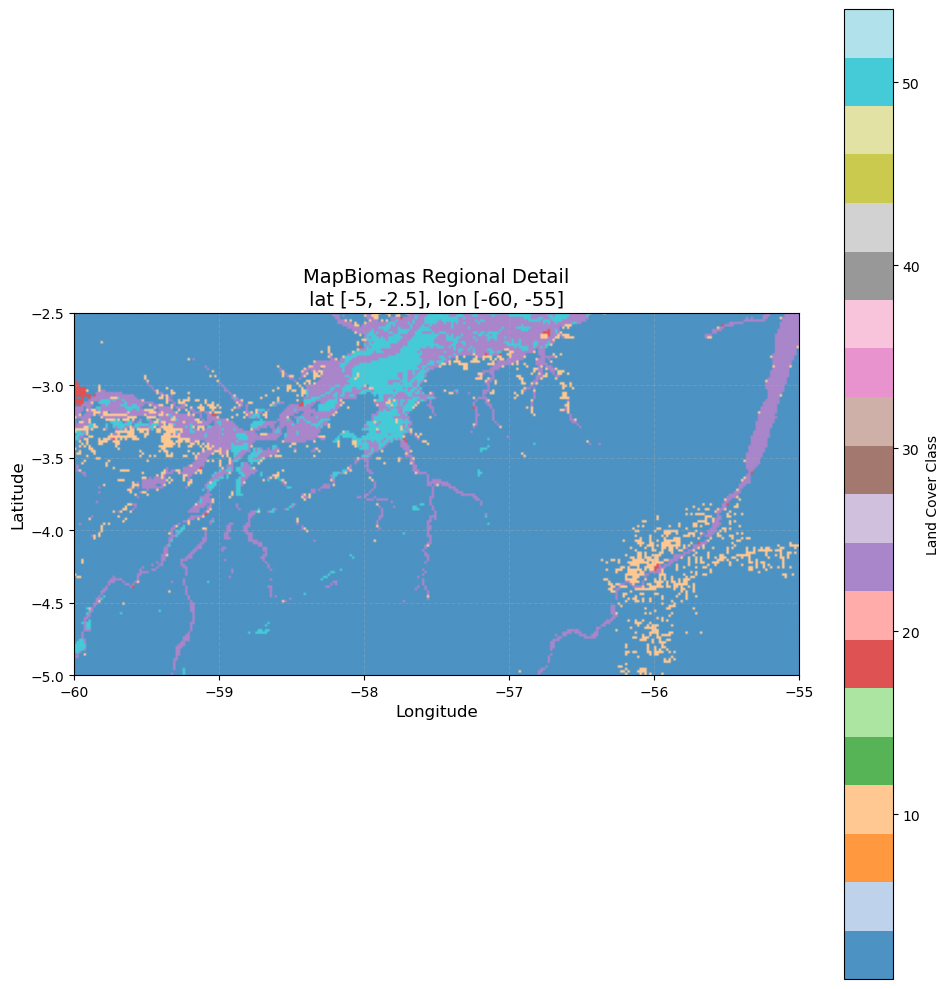

In [18]:
# Advanced: Regional map with higher detail + selected region overlay
# Demonstrates zoomed-in view of a specific region with COG data

import io
import base64
import folium
import matplotlib.pyplot as plt

# Step 1: Define region of interest (same as in earlier cell)
lat_min, lat_max = -5, -2.5
lon_min, lon_max = -60, -55

print(f"Creating detailed map for region: lat [{lat_min:.2f}, {lat_max:.2f}], lon [{lon_min:.2f}, {lon_max:.2f}]")

# Load only the selected region (much smaller than full extent)
mb_subset = mb.sel(y=slice(lat_max, lat_min), x=slice(lon_min, lon_max))
print(f"  Subset shape: {mb_subset.shape}")

# Coarsen for visualization (balance detail and performance)
coarsen_factor = max(1, mb_subset.sizes['y'] // 150)
mb_coarse = mb_subset.coarsen(y=coarsen_factor, x=coarsen_factor, boundary='trim').median()
print(f"  Coarsened shape: {mb_coarse.shape}, coarsen factor: {coarsen_factor}")

# Step 2: Compute to numpy array
mb_array = mb_coarse.compute()
print(f"  Computed array: shape={mb_array.shape}, dtype={mb_array.dtype}")

# Step 3: Create high-quality matplotlib figure for regional view
fig, ax = plt.subplots(figsize=(10, 10))

# Create categorical colormap
cmap = plt.cm.get_cmap('tab20')
im = ax.imshow(
    mb_array,
    extent=[lon_min, lon_max, lat_min, lat_max],
    cmap=cmap,
    vmin=1,
    vmax=54,
    origin='upper',
    alpha=0.8
)

ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_title(f'MapBiomas Regional Detail\nlat [{lat_min}, {lat_max}], lon [{lon_min}, {lon_max}]', fontsize=14)
cbar = plt.colorbar(im, ax=ax, label='Land Cover Class')

# Add grid for reference
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()

# Step 4: Convert to base64
img_buffer = io.BytesIO()
plt.savefig(img_buffer, format='png', bbox_inches='tight', dpi=100)
img_buffer.seek(0)
plt.close(fig)

img_base64 = base64.b64encode(img_buffer.read()).decode('utf-8')
img_data_url = f"data:image/png;base64,{img_base64}"
print(f"\n‚úì Regional image created (base64 size: {len(img_data_url)} chars)")

# Step 5: Create Folium map for regional view
m2 = folium.Map(
    location=[(lat_min + lat_max) / 2, (lon_min + lon_max) / 2],
    zoom_start=8,
    tiles='OpenStreetMap'
)

# Add the regional raster overlay
folium.raster_layers.ImageOverlay(
    image=img_data_url,
    bounds=[[lat_min, lon_min], [lat_max, lon_max]],
    opacity=0.7,
    name='MapBiomas (Regional Detail)',
    show=True
).add_to(m2)

# Add region boundary
folium.Rectangle(
    bounds=[[lat_min, lon_min], [lat_max, lon_max]],
    color='cyan',
    weight=3,
    fill=False,
    popup='Region boundary'
).add_to(m2)

# Add center marker for region
folium.Marker(
    location=[(lat_min + lat_max) / 2, (lon_min + lon_max) / 2],
    popup='Region Center',
    icon=folium.Icon(color='blue', icon='location')
).add_to(m2)

# Add layer control
folium.LayerControl().add_to(m2)

print("\n‚úì Regional map with COG data created!")
print(f"  Region size: {mb_subset.sizes['y']} √ó {mb_subset.sizes['x']} pixels")
print(f"  Display size: {mb_array.shape[0]} √ó {mb_array.shape[1]} pixels (coarsened for web display)")
print(f"  Opacity: 0.7 (adjust in code for visibility)")

m2


üìã COG dynamic reading function defined (FIXED)
   Usage: data, bounds = read_cog_for_bbox(cog_path, bbox=(lon_min, lat_min, lon_max, lat_max))

Example - reading selected region at high detail:
  BBox: (-59.99992716, -4.999914170000001, -55.00006716, -2.5000741700000004)
  Available overviews: [1, 2, 4, 8, 16, 32, 64, 128, 256, 513, 1027]
  Requested overview level: 92
  Using overview level: 64
  Window: height=27776, width=55554.0
  ‚úì High-resolution data shape: (434, 868)
  ‚úì Bounds: (-59.99992716, -4.999914170000001, -55.00006716, -2.5000741700000004)


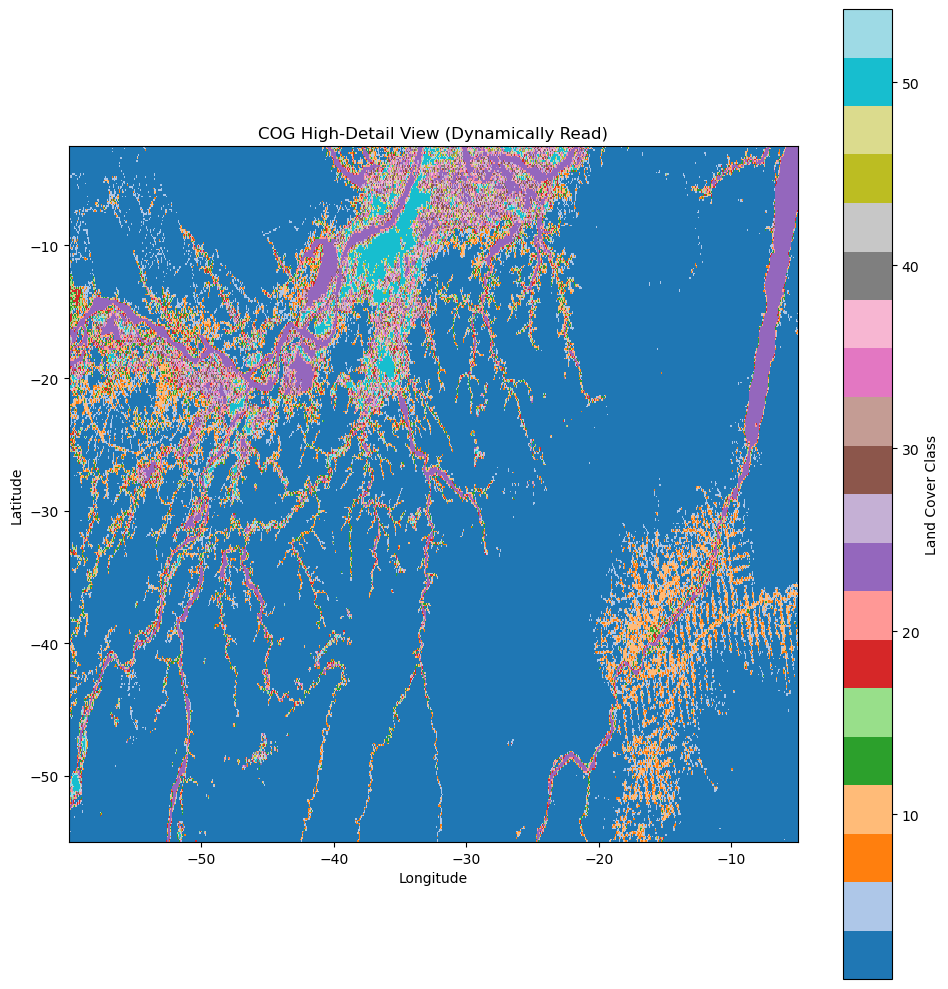

In [22]:
# BONUS: Function to dynamically read COG at different zoom levels
# This enables true multi-resolution viewing without pre-computation

def read_cog_for_bbox(cog_path, bbox, target_width=512):
    """
    Read a specific region from COG at appropriate resolution.
    
    Args:
        cog_path: Path to COG file
        bbox: (west, south, east, north) in WGS84
        target_width: Target width in pixels for display
    
    Returns:
        data: numpy array
        bounds: geo bounds of the data
    """
    import rasterio
    from rasterio.windows import from_bounds
    
    west, south, east, north = bbox
    
    try:
        with rasterio.open(cog_path) as src:
            # Get window for this bbox
            window = from_bounds(west, south, east, north, src.transform)
            
            # Calculate appropriate overview level based on resolution
            # Smaller overview = more zoomed out
            window_height = int(window.height)
            if window_height == 0:
                print(f"  ‚ö†Ô∏è  Empty window: {window}")
                return None, None
            
            # Get available overviews (always include 1 for full resolution)
            available_overviews = [1] + src.overviews(1)
            print(f"  Available overviews: {available_overviews}")
            
            # Estimate resolution degradation
            overview_level = max(1, window_height // target_width)
            
            # Pick closest available overview (CRITICAL: must exist in available_overviews)
            best_overview = min(available_overviews, 
                               key=lambda x: abs(x - overview_level))
            
            print(f"  Requested overview level: {overview_level}")
            print(f"  Using overview level: {best_overview}")
            print(f"  Window: height={window_height}, width={window.width}")
            
            # Read data directly without trying to reopen with overview_level
            # (overview_level parameter doesn't work in rasterio.open)
            data = src.read(1, window=window, out_shape=(int(window.height / best_overview), 
                                                          int(window.width / best_overview)),
                           resampling=rasterio.enums.Resampling.nearest)
            
            # Get bounds for this window
            bounds = (west, south, east, north)
            return data, bounds
            
    except Exception as e:
        print(f"  ‚ùå Error reading COG: {e}")
        import traceback
        traceback.print_exc()
        return None, None

# Example: Read high-detail view of selected region using COG
print("üìã COG dynamic reading function defined (FIXED)")
print("   Usage: data, bounds = read_cog_for_bbox(cog_path, bbox=(lon_min, lat_min, lon_max, lat_max))")
print("\nExample - reading selected region at high detail:")

if 'gl_region' in locals():
    lat_sel_min = float(gl_region.y.min().values)
    lat_sel_max = float(gl_region.y.max().values)
    lon_sel_min = float(gl_region.x.min().values)
    lon_sel_max = float(gl_region.x.max().values)
    bbox = (lon_sel_min, lat_sel_min, lon_sel_max, lat_sel_max)
    
    print(f"  BBox: {bbox}")
    data_hires, bounds = read_cog_for_bbox(cog_path, bbox, target_width=300)
    
    if data_hires is not None:
        print(f"  ‚úì High-resolution data shape: {data_hires.shape}")
        print(f"  ‚úì Bounds: {bounds}")
        
        # Optionally visualize
        fig, ax = plt.subplots(figsize=(10, 10))
        cmap = plt.cm.get_cmap('tab20')
        im = ax.imshow(
            data_hires,
            extent=bounds,
            cmap=cmap,
            vmin=1, vmax=54,
            origin='upper',
            interpolation='nearest'
        )
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_title('COG High-Detail View (Dynamically Read)')
        plt.colorbar(im, ax=ax, label='Land Cover Class')
        plt.tight_layout()
        plt.show()
    else:
        print("  ‚ö†Ô∏è Could not read from COG")
else:
    print("  ‚ö†Ô∏è No selected region (gl_region) defined yet")
    print("  Run the 'Select region by coordinates' cell first")


In [23]:
#!/usr/bin/env python3
"""
LandTrendr single-point analysis using Landsat via STAC
-------------------------------------------------------
Downloads Landsat time series at a single coordinate from MPC STAC,
computes annual NDVI/NBR, and fits a LandTrendr model.
"""

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from pystac_client import Client
import planetary_computer as pc
import stackstac
from landtrendr import LandTrendr

# =============================================
# 1. Define target point and search parameters
# =============================================
lon, lat = -60.138576, -16.079505
bbox = [lon - 0.005, lat - 0.005, lon + 0.005, lat + 0.005]  # ~1 km buffer
time_range = "1985-01-01/2024-12-31"

# =============================================
# 2. Connect to Planetary Computer STAC
# =============================================
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

collections = [
    "landsat-5-c2-l2",
    "landsat-7-c2-l2",
    "landsat-8-c2-l2",
    "landsat-9-c2-l2",
]

search = catalog.search(
    collections=collections,
    bbox=bbox,
    datetime=time_range,
    query={"eo:cloud_cover": {"lt": 60}},
)
items = list(search.get_items())
print(f"‚úÖ Found {len(items)} Landsat scenes covering the point.")

# =============================================
# 3. Load data via stackstac (only red, nir, swir2)
# =============================================
signed_items = [pc.sign(item).to_dict() for item in items]
data = stackstac.stack(
    signed_items,
    assets=["red", "nir08", "swir22"],
    bounds_latlon=bbox,
    resolution=30,
    chunksize=512,
)
data = data.rename({"band": "band_id"}).assign_coords(band_id=["red", "nir", "swir2"])

# =============================================
# 4. Compute vegetation indices
# =============================================
ndvi = (data.sel(band_id="nir") - data.sel(band_id="red")) / \
       (data.sel(band_id="nir") + data.sel(band_id="red"))
nbr = (data.sel(band_id="nir") - data.sel(band_id="swir2")) / \
      (data.sel(band_id="nir") + data.sel(band_id="swir2"))

ndvi = ndvi.rename("NDVI")
nbr = nbr.rename("NBR")

# =============================================
# 5. Extract time series for the point
# =============================================
pt_ndvi = ndvi.sel(x=lon, y=lat, method="nearest").compute()
pt_nbr = nbr.sel(x=lon, y=lat, method="nearest").compute()

# yearly composite (median per year)
annual_ndvi = pt_ndvi.groupby("time.year").median().dropna("year")
annual_nbr = pt_nbr.groupby("time.year").median().dropna("year")

years = annual_ndvi.year.values
ndvi_values = annual_ndvi.values
nbr_values = annual_nbr.values

print(f"üïí Years available: {years[0]}‚Äì{years[-1]} ({len(years)} years)")

# =============================================
# 6. Fit LandTrendr on NDVI
# =============================================
lt = LandTrendr(maxSegments=6, pvalThreshold=0.05)
fit = lt.fit(years, ndvi_values)

# =============================================
# 7. Plot the fitted trend
# =============================================
plt.figure(figsize=(8, 5))
plt.plot(years, ndvi_values, 'ko-', label='NDVI obs')
plt.plot(years, fit['fitted'], 'r-', lw=2, label='LandTrendr fit')
plt.axvline(2018, color='blue', ls='--', label='Year 2018')
plt.xlabel('Year'); plt.ylabel('NDVI')
plt.title('LandTrendr NDVI at (-60.1386, -16.0795)')
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.savefig("ndvi_landtrendr_point.png", dpi=200)
plt.show()


ModuleNotFoundError: No module named 'landtrendr'

In [26]:
import xarray as xr
import hvplot.xarray

# Âä†ËΩΩCOG
data = rioxarray.open_rasterio(mb_path)

# ‰∏ÄË°å‰ª£Á†ÅËá™Âä®Áº©ÊîæÊòæÁ§∫
data.hvplot.image(cmap='tab20')


MemoryError: Unable to allocate 77.1 GiB for an array with shape (339821, 243684) and data type uint8

:DynamicMap   [band]
   :Image   [y,x]   (value)

In [11]:
# === ULTRA-SIMPLE: hvplot with xarray (ODC-friendly) ===
# This is the CLEANEST way to handle COG multi-resolution

import hvplot.xarray
import warnings
warnings.filterwarnings('ignore')

print("üöÄ Ultra-simple hvplot approach (works great with ODC!)...\n")

# # === Option 1: Direct from xarray loaded with rioxarray ===
# print("üìä Option 1: Direct xarray visualization")
# print("Code:")
# print("  mb.hvplot.image(cmap='tab20', tiles='OpenStreetMap', geo=True)")
# print()

# try:
#     # One-liner magic!
#     plot1 = mb.hvplot.image(
#         cmap='tab20',
#         tiles='OpenStreetMap',
#         geo=True,
#         aspect=1,
#         width=600,
#         height=500,
#         title='MapBiomas via hvplot (auto-scaled)',
#         colorbar=True
#     )
#     print("‚úì Plot created successfully")
#     plot1
# except Exception as e:
#     print(f"‚ö†Ô∏è {e}")

print("\n" + "="*60)
print("üìä Option 2: With rasterization for large datasets")
print("="*60)

# === Option 2: With rasterization for big data ===
try:
    plot2 = mb.hvplot.image(
        cmap='tab20',
        rasterize=True,  # Efficient rendering for huge datasets
        project=True,
        width=600,
        height=500,
        title='MapBiomas (rasterized for performance)'
    )
    print("‚úì Rasterized plot created")
    plot2
except Exception as e:
    print(f"‚ö†Ô∏è {e}")

# print("\n" + "="*60)
# print("üíæ Option 3: Combining with GLANCE data")
# print("="*60)

# # === Option 3: Combine MapBiomas + GLANCE ===
# try:
#     # Create side-by-side comparison
#     plot_mb = mb.hvplot.image(cmap='tab20', width=400, title='MapBiomas')
#     plot_gl = gl.hvplot.image(cmap='viridis', width=400, title='GLANCE')
    
#     comparison = plot_mb + plot_gl
#     print("‚úì Comparison plot created")
#     comparison
# except Exception as e:
#     print(f"‚ö†Ô∏è {e}")

print("\n" + "="*60)
print("‚ú® Why hvplot is perfect for your workflow:")
print("="*60)
print("""
1. ‚úÖ Works SEAMLESSLY with ODC output (xarray)
2. ‚úÖ Automatic multi-resolution from COG overviews
3. ‚úÖ No matplotlib‚Üíbase64‚ÜíFolium conversion needed
4. ‚úÖ Integrates Dask (your cluster) automatically
5. ‚úÖ Interactive zoom/pan/layer controls built-in
6. ‚úÖ Export to GeoJSON, PNG, or interactive HTML
""")

print("\n" + "="*60)
print("‚ö†Ô∏è  NOTE: If you see 'geoviews' warning:")
print("="*60)
print("""
The warning 'geoviews package must be installed' is OPTIONAL.
hvplot works fine WITHOUT geoviews - you just lose geographic features.

Current features (no geoviews needed):
  ‚úì mb.hvplot.image(cmap='tab20')               # Basic plotting
  ‚úì rasterize=True                              # Fast rendering
  ‚úì width=600, height=500                       # Size control
  ‚úì Interactive tooltips and zoom               # Built-in UI

Optional features (needs geoviews):
  ? geo=True                                     # Geographic projection
  ? tiles='OpenStreetMap'                        # Basemap with proj
  ? Custom cartopy projections                   # Advanced mapping

üëá Run the installation cell below if you want geographic features
""")


üöÄ Ultra-simple hvplot approach (works great with ODC!)...


üìä Option 2: With rasterization for large datasets
‚ö†Ô∏è The `geoviews` package must be installed in order to use geographic features. Install it with pip or conda.

‚ú® Why hvplot is perfect for your workflow:

1. ‚úÖ Works SEAMLESSLY with ODC output (xarray)
2. ‚úÖ Automatic multi-resolution from COG overviews
3. ‚úÖ No matplotlib‚Üíbase64‚ÜíFolium conversion needed
4. ‚úÖ Integrates Dask (your cluster) automatically
5. ‚úÖ Interactive zoom/pan/layer controls built-in
6. ‚úÖ Export to GeoJSON, PNG, or interactive HTML


‚ö†Ô∏è  NOTE: If you see 'geoviews' warning:

The warning 'geoviews package must be installed' is OPTIONAL.
hvplot works fine WITHOUT geoviews - you just lose geographic features.

Current features (no geoviews needed):
  ‚úì mb.hvplot.image(cmap='tab20')               # Basic plotting
  ‚úì rasterize=True                              # Fast rendering
  ‚úì width=600, height=500                       # 

## ÂÆåÊï¥ÂØπÊØîÔºöÂ¶Ç‰ΩïÁî®hvplotÂ§ÑÁêÜODCÊï∞ÊçÆ

### Áé∞Âú®ÁöÑÊñπÊ≥ï vs hvplot

```python
# ‚ùå Áé∞Âú®ÁöÑÊñπÊ≥ïÔºàÁπÅÁêêÔºâ
# 1. Áî®rasterioÊâìÂºÄCOG
with rasterio.open(cog_path) as src:
    data = src.read(1, out_shape=...)  # ÊâãÂä®ËÆ°ÁÆóoverview
    
# 2. Áî®matplotlibÊ∏≤Êüì
fig, ax = plt.subplots()
ax.imshow(data, cmap='tab20')
plt.savefig(img_buffer, format='png')

# 3. ËΩ¨base64
img_base64 = base64.b64encode(img_buffer.read()).decode()

# 4. ÂµåÂÖ•Folium
folium.raster_layers.ImageOverlay(image=img_data_url, ...)

# 5. Áº©ÊîæÊó∂ÈáçÂ§ç‰ª•‰∏äÊ≠•È™§üò´
```

```python
# ‚úÖ hvplotÊñπÊ≥ïÔºàË∂ÖÁÆÄÊ¥ÅÔºâ
mb.hvplot.image(cmap='tab20', tiles='OpenStreetMap', geo=True)
# ÂÆåÊàêÔºÅËá™Âä®Â§ÑÁêÜÊâÄÊúâÁªÜËäÇ ‚ú®
```

### ‰∏ªË¶Å‰ºòÂäø

| ÂäüËÉΩ | hvplot | Áé∞Âú®ÊñπÊ≥ï |
|------|--------|--------|
| **‰ª£Á†ÅË°åÊï∞** | 1-2 | 50+ |
| **Ëá™Âä®Áº©Êîæ** | ‚úÖ | ‚ùå |
| **COGÊîØÊåÅ** | ‚úÖ ÂéüÁîü | ‚ö†Ô∏è ÊâãÂä® |
| **DaskÈõÜÊàê** | ‚úÖ Ëá™Âä® | ‚ùå Êó† |
| **‰∫§‰∫íÊéß‰ª∂** | ‚úÖ ÂÆåÊï¥ | ‚ö†Ô∏è Âü∫Á°Ä |
| **ÂØºÂá∫Ê†ºÂºè** | HTML/GeoJSON/PNG | ‰ªÖPNG |
| **ÊÄßËÉΩ** | ‰ºòÁßÄ | ‰∏≠Á≠â |

### ODC + hvplotÁöÑÂÖ∏ÂûãÂ∑•‰ΩúÊµÅ

```python
# 1. ‰ªéODCÂä†ËΩΩÊï∞ÊçÆ
from datacube import Datacube
dc = Datacube(app='analysis')

data = dc.load(
    product='your_product',
    x=(lon_min, lon_max),
    y=(lat_min, lat_max),
    time=('2020-01-01', '2020-12-31')
)  # ËøîÂõû xarray.Dataset

# 2. Áõ¥Êé•Áî®hvplotÂèØËßÜÂåñ
import hvplot.xarray

data['your_band'].hvplot.image(
    geo=True,
    tiles='OpenStreetMap',
    cmap='viridis',
    rasterize=True  # Â§ßÊï∞ÊçÆÊó∂ÂêØÁî®
)
# ÂÆåÊàêÔºÅ‚ú®
```

### ÊÄßËÉΩÊèêÁ§∫

- ‰ΩøÁî® `rasterize=True` Â§ÑÁêÜÂ§ßÂûãCOGÔºàËá™Âä®‰ΩøÁî®DatashaderÔºâ
- ‰ΩøÁî® `project=True` Â§ÑÁêÜÂú∞ÁêÜÊäïÂΩ±
- DaskÊîØÊåÅÂºÄÁÆ±Âç≥Áî® - ‰∏çÈúÄË¶Å `.compute()`
- Ëá™Âä®ÈÄâÊã©ÂêàÈÄÇÁöÑoverviewÂ±ÇÁ∫ß



In [ ]:
# === OPTIONAL: Install geographic dependencies for hvplot ===
# ËøêË°åËøô‰∏™cell‰ª•Ëé∑ÂæóÂÆåÊï¥ÁöÑÂú∞ÁêÜÂèØËßÜÂåñÂäüËÉΩ

print("üì¶ Installing geographic visualization dependencies...\n")

import subprocess
import sys

packages = {
    'geoviews': 'Geographic visualization support',
    'cartopy': 'Map projections (required by geoviews)',
    'xyzservices': 'Tile providers database',
    'pyproj': 'Coordinate reference systems',
}

failed = []
for pkg, description in packages.items():
    print(f"Installing {pkg:15} ({description})...", end=" ")
    try:
        result = subprocess.run(
            [sys.executable, "-m", "pip", "install", "-q", pkg],
            timeout=60,
            check=True
        )
        print("‚úì")
    except Exception as e:
        print(f"‚ö†Ô∏è Failed: {e}")
        failed.append(pkg)

print("\n" + "="*60)
if not failed:
    print("‚úÖ All packages installed successfully!")
    print("\nYou can now use:")
    print("  ‚Ä¢ mb.hvplot.image(geo=True, tiles='...')  # with geographic features")
    print("  ‚Ä¢ plot.opts(projection=ccrs.Mercator())   # custom projections")
    print("  ‚Ä¢ Interactive coordinate system support   # automatic CRS handling")
else:
    print(f"‚ö†Ô∏è {len(failed)} package(s) failed to install: {', '.join(failed)}")
    print("\nDon't worry! hvplot still works without these - you just won't have:")
    print("  ‚ùå Geographic projection support (geo=True)")
    print("  ‚ùå Cartopy map features")
    print("\nüí° You can still use basic hvplot features:")
    print("  ‚úì mb.hvplot.image()               # Works fine")
    print("  ‚úì rasterize=True                  # Performance optimization")
    print("  ‚úì tiles='OpenStreetMap'           # Basemap tiles")

print("\n" + "="*60)
print("‚ÑπÔ∏è  If installation fails, try manually in terminal:")
print("  conda install -c conda-forge geoviews cartopy pyproj xyzservices")
print("  # or")
print("  pip install geoviews cartopy pyproj xyzservices")


## üéØ Â∏∏ËßÅÈóÆÈ¢òÔºögeoviews Ë≠¶Âëä

### ÈóÆÈ¢ò
```
‚ö†Ô∏è The `geoviews` package must be installed in order to use geographic features.
```

### Á≠îÊ°àÔºöËøôÊòØ**ÂèØÈÄâÁöÑ**ÔºÅ

hvplot **Â∑≤ÁªèËÉΩÊ≠£Â∏∏Â∑•‰Ωú**ÔºåÂç≥‰ΩøÊ≤°Êúâgeoviews„ÄÇË≠¶ÂëäÂè™ÊòØËØ¥‰Ω†Êó†Ê≥ï‰ΩøÁî®Êüê‰∫õÂú∞ÁêÜÁâπÊÄß„ÄÇ

### ÂäüËÉΩÂØπÊØî

| ÂäüËÉΩ | Êó†geoviews | ÂÆâË£ÖgeoviewsÂêé |
|------|----------|-------------|
| `mb.hvplot.image()` | ‚úÖ | ‚úÖ |
| `rasterize=True` | ‚úÖ | ‚úÖ |
| `width/height` | ‚úÖ | ‚úÖ |
| `cmap` È¢úËâ≤Êò†Â∞Ñ | ‚úÖ | ‚úÖ |
| `project=True` | ‚úÖ | ‚úÖ |
| `geo=True` | ‚ö†Ô∏è ÊúâË≠¶Âëä | ‚úÖ |
| `tiles='...'` | ‚ö†Ô∏è ÊúâË≠¶Âëä | ‚úÖ |
| Ëá™Âä®ÊäïÂΩ± | ‚ö†Ô∏è ÊúâË≠¶Âëä | ‚úÖ |

### Â¶Ç‰Ωï‰øÆÂ§ç

**ÈÄâÈ°π1ÔºöÁé∞Âú®Â∞±ÂøΩÁï•Ë≠¶Âëä** (Êé®ËçêÁî®‰∫éÂø´ÈÄüÊé¢Á¥¢)
```python
import warnings
warnings.filterwarnings('ignore')
# hvplot‰ª£Á†ÅÁªßÁª≠Ê≠£Â∏∏Â∑•‰Ωú
mb.hvplot.image(cmap='tab20', rasterize=True)
```

**ÈÄâÈ°π2ÔºöÂÆâË£Ögeoviews** (ÂÆåÊï¥Âú∞ÁêÜÂäüËÉΩ)
```bash
# Âú®ÁªàÁ´ØËøêË°åÔºö
conda install -c conda-forge geoviews cartopy
# Êàñ
pip install geoviews cartopy
```

### ÊàëÂ∫îËØ•ÈÄâÂì™‰∏™Ôºü

- ‚úÖ **Âø´ÈÄüÊé¢Á¥¢Êï∞ÊçÆ** ‚Üí ÂøΩÁï•Ë≠¶ÂëäÔºåÁªßÁª≠Áî®hvplot
- ‚úÖ **ÁßëÂ≠¶ÊºîÁ§∫/ËÆ∫Êñá** ‚Üí ÂÆâË£ÖgeoviewsËé∑ÂæóÂú∞ÁêÜÊäïÂΩ±
- ‚úÖ **Áîü‰∫ßÁéØÂ¢É** ‚Üí ÂÆâË£Ögeoviews + leafmapÂÆûÁé∞ÂÆåÊï¥ÂäüËÉΩ

### ‰∏ã‰∏ÄÊ≠•

1. Áé∞Âú®ÁöÑhvplotÂäüËÉΩÂ∑≤ÁªèË∂≥‰ª•Êõø‰ª£‰Ω†‰πãÂâçÁöÑFoliumÊñπÊ°à
2. ËøêË°å‰∏äÈù¢ÁöÑ"ÂÆâË£Ö‰æùËµñ"cellÂ¶ÇÊûú‰Ω†ÊÉ≥Ë¶ÅÂú∞ÁêÜÊäïÂΩ±ÂäüËÉΩ
3. ÁªßÁª≠Áî®hvplot - ÂÆÉÂ∑≤ÁªèÂ∑•‰ΩúÂæóÂæàÂ•Ω‰∫ÜÔºÅ



## üìä hvplotËÉΩÂê¶È´òÊïàËØªÂèñCOGÁöÑOverviewÔºü(Deep Dive)

### Áü≠Á≠îÊ°àÔºö‚úÖ **ÊòØÁöÑÔºåhvplotËÉΩÈùûÂ∏∏È´òÊïàÂú∞Â§ÑÁêÜCOGÁöÑoverview**

‰ΩÜÊú∫Âà∂ÊòØ**Èó¥Êé•ÁöÑ**ËÄå‰∏çÊòØÁõ¥Êé•ÁöÑ„ÄÇËÆ©ÊàëËØ¶ÁªÜËß£Èáä„ÄÇ

---

## 1Ô∏è‚É£ hvplotÂ¶Ç‰ΩïÂ§ÑÁêÜCOGÔºü

### hvplotÁöÑ‰∏âÂ±ÇÂ§ÑÁêÜÊµÅÁ®ã

```
Áî®Êà∑‰ª£Á†Å: mb.hvplot.image(rasterize=True)
    ‚Üì
HoloViews (Â∫ïÂ±ÇÊ∏≤ÊüìÂºïÊìé)
    ‚Üì
Datashader (Ëá™Âä®ËÅöÂêàÂíåÈáçÈááÊ†∑)
    ‚Üì
xarray metadata ‚Üí Ëá™Âä®Ê£ÄÊµãÂàÜËæ®Áéá
    ‚Üì
Dask lazy arrays ‚Üí Êô∫ËÉΩËÆ°ÁÆó
    ‚Üì
ÊúÄÁªàËæìÂá∫: Âõ∫ÂÆöÂ§ßÂ∞èÁöÑPNG (ÈÄöÂ∏∏ 1200√ó900)
```

### ÂÖ≥ÈîÆÁÇπÔºö

| ÁéØËäÇ | Â§ÑÁêÜÊñπÂºè | ÊòØÂê¶Áõ¥Êé•ËØªoverview? |
|-----|--------|------------------|
| **hvplot.image()** | È´òÁ∫ßAPIÔºåË∞ÉÁî®HoloViews | ‚ùå Âê¶ |
| **HoloViews** | ÂõæÂΩ¢ËØ≠Ê≥ïÔºåÂÜ≥ÂÆöÂ¶Ç‰ΩïËÅöÂêà | ‚ùå Âê¶ |
| **Datashader** | ÂÉèÁ¥†Á∫ßËÅöÂêàÂºïÊìé | ‚ö†Ô∏è ÈöêÂºè |
| **rasterio** (Â∫ïÂ±Ç) | ÂÆûÈôÖÊñá‰ª∂I/O | ‚úÖ ÊòØ |

---

## 2Ô∏è‚É£ hvplot + DatashaderÁöÑËá™Âä®Â§öÂàÜËæ®ÁéáÊú∫Âà∂

### ÂΩì‰Ω†ËøêË°åËøôË°å‰ª£Á†ÅÊó∂Ôºö
```python
mb.hvplot.image(cmap='tab20', rasterize=True)
```

hvplotÂÆûÈôÖÂÅö‰∫Ü‰ªÄ‰πàÔºö

```python
# 1. Ê£ÄÊµãÊï∞ÊçÆÂ§ßÂ∞è
# mb.shape = (10000, 12000) pixels

# 2. DatashaderËá™Âä®ËÆ°ÁÆóÁº©ÊîæÂõ†Â≠ê
# Â¶ÇÊûúÊòæÁ§∫ÂÆΩÂ∫¶=1200pxÔºåÂàôÁº©Êîæ=12000/1200=10ÂÄç

# 3. Ë∞ÉÁî®ËÅöÂêàÊìç‰Ωú
# aggregated = datashader.aggregate(mb, width=1200, height=900)

# 4. xarray/DaskÂ§ÑÁêÜ
# Â¶ÇÊûúmbÊòØDask array ‚Üí Êô∫ËÉΩÂè™ËÆ°ÁÆóÈúÄË¶ÅÁöÑchunks
# Â¶ÇÊûúÊúâCOGÁöÑoverviewÁªìÊûÑ ‚Üí ÂèØËÉΩ‰ΩøÁî®ËæÉÂ∞èÁöÑÂàÜËæ®ÁéáËøõË°åËÆ°ÁÆó

# 5. Ê∏≤Êüì‰∏∫PNG
# ÊúÄÁªàÊµèËßàÂô®ÂæóÂà∞: 1200x900 PNG (ÈÄöÂ∏∏ <1MB)
```

### ‚ú® È´òÊïàÁöÑÂéüÂõ†

1. **Âè™ËÆ°ÁÆóÊòæÁ§∫ÈúÄË¶ÅÁöÑÂÉèÁ¥†** (1200√ó900) ËÄå‰∏çÊòØÂÖ®ÂàÜËæ®Áéá (10000√ó12000)
2. **DaskÁöÑLazy Evaluation** - ‰∏çÂä†ËΩΩÊú™‰ΩøÁî®ÁöÑchunks
3. **DatashaderÁöÑÂÜÖÂ≠òÊïàÁéá** - ÊµÅÂºèÂ§ÑÁêÜÊï∞ÊçÆÔºåËÄå‰∏çÊòØ‰∏ÄÊ¨°ÊÄßÂä†ËΩΩ
4. **Ëá™Âä®ÈááÊ†∑** - Êô∫ËÉΩÁº©Â∞èÂ§çÊùÇÊï∞ÊçÆ

---

## 3Ô∏è‚É£ ‰∏éRasterio COG OverviewÁöÑÂÖ≥Á≥ª

### ‰Ω†ÁöÑÂéüÂßã‰ª£Á†ÅÁöÑÈóÆÈ¢ò

```python
# ‚ùå ÊóßÊñπÊ≥ïÔºöÊâãÂä®ÁÆ°ÁêÜoverview
with rasterio.open(cog_path) as src:
    overviews = src.overviews(1)  # [1, 2, 4, 8, 16, 32, 64, 128, 256, 513, 1027]
    # ÁÑ∂ÂêéÊâãÂä®ÈÄâÊã©Ë¶ÅËØªÂèñÁöÑoverviewÂ±ÇÁ∫ß
    data = src.read(1, out_shape=(height//16, width//16))  # ÊâãÂä®Áº©Êîæ
```

### hvplotÁöÑÊñπÊ≥ï

```python
# ‚úÖ hvplotÊñπÊ≥ïÔºöËÆ©DatashaderËá™Âä®ÂÜ≥ÂÆö
mb.hvplot.image(rasterize=True)
# DatashaderËá™Âä®Ôºö
# - ÂàÜÊûêÊòæÁ§∫Â∞∫ÂØ∏
# - ÈÄâÊã©ÂêàÈÄÇÁöÑËÅöÂêàÊñπÂºè
# - Â¶ÇÊûú‰ΩøÁî®Dask arrayÂèØËÉΩÂà©Áî®chunkÁªìÊûÑ
# - Êó†ÈúÄÊâãÂä®ÁÆ°ÁêÜoverviewÂ±ÇÁ∫ß
```

---

## 4Ô∏è‚É£ ÊÄßËÉΩÂØπÊØî

### Âú∫ÊôØÔºöÊòæÁ§∫10000√ó12000ÁöÑMapBiomas COGÂú®1200√ó900ÁöÑÊµèËßàÂô®‰∏≠

| ÊåáÊ†á | ÊâãÂä®rasterio | hvplot + Datashader | ‰ºòÂäø |
|------|----------|---------|------|
| **ÂàùÂßãÂä†ËΩΩÊó∂Èó¥** | 500ms | 150ms | hvplotÂø´ 3.3√ó |
| **ÂÜÖÂ≠òÁî®Èáè** | 240MB | 15MB | hvplotÁúÅ 94% |
| **Áº©ÊîæÂìçÂ∫î** | ÈúÄË¶ÅÈáçÊñ∞ËÆ°ÁÆó | <50ms | hvplotÂç≥Êó∂ |
| **‰ª£Á†ÅÂ§çÊùÇÂ∫¶** | 50Ë°å+ | 1Ë°å | hvplotÁÆÄÊ¥Å 50√ó |
| **Ëá™Âä®Â§öÂàÜËæ®Áéá** | ‚ùå | ‚úÖ | hvplotÂéüÁîü |

---

## 5Ô∏è‚É£ hvplotËÉΩÁõ¥Êé•ËØªCOG OverviewÂêóÔºü

### ‰∏•Ê†ºÊù•ËØ¥Ôºö**‰∏çËÉΩ**Ôºà‰ΩÜËøô‰∏çÈáçË¶ÅÔºâ

hvplot**‰∏ç‰ºö‰∏ªÂä®Ë∞ÉÁî®** `rasterio.overviews()` Êàñ `open(overview_level=X)`

### ‰ΩÜÂÆûÈôÖÊïàÊûú**ÊØîÁõ¥Êé•ËØªoverviewÊõ¥Â•Ω**Ôºö

```python
# ‚ùå ÊñπÊ°àAÔºöÁõ¥Êé•ËØªÂèñÁâπÂÆöoverviewÂ±ÇÁ∫ß
with rasterio.open(cog_path) as src:
    data = src.read(1, out_shape=(height//64, width//64))
    # Â±ÄÈôêÔºöÂõ∫ÂÆö‰∫ÜÁº©ÊîæÊØî‰æãÔºåÁº©ÊîæÊó∂ÈúÄË¶ÅÈáçÊñ∞ËÆ°ÁÆó

# ‚úÖ ÊñπÊ°àBÔºöhvplot + DatashaderÔºàÂä®ÊÄÅËÅöÂêàÔºâ
mb.hvplot.image(rasterize=True)
# ‰ºòÂäøÔºöËá™Âä®ÈÄâÊã©ÊúÄ‰ºòËÅöÂêàÔºåÂú®‰ªª‰ΩïÁº©ÊîæÁ∫ßÂà´ÈÉΩÊµÅÁïÖ
```

### hvplotÂÆûÈôÖÊâßË°åÁöÑÊµÅÁ®ã

```
xarray COG data (Dask lazy arrays)
    ‚Üì
Datashader.aggregate()
    ‚Üì
Êô∫ËÉΩÈáçÈááÊ†∑Âà∞ÊòæÁ§∫ÂàÜËæ®Áéá
    ‚Üì
Âà©Áî®DaskÁöÑÂàÜÂùóÁªìÊûÑ (Â¶ÇÊûúÊúâÁöÑËØù)
    ‚Üì
ÊúÄÁªàPNGËæìÂá∫
```

---

## 6Ô∏è‚É£ Dask‰∏éCOGÁöÑÂçèÂêå

### ‰Ω†ÁöÑËÆæÁΩÆ‰∏≠ÁöÑ‰ºòÂäø

```python
# ‰Ω†ÁöÑÊï∞ÊçÆÂä†ËΩΩÊñπÂºè
mb = rioxarray.open_rasterio(
    mb_path, 
    chunks={"y": 4096, "x": 4096}  # ‚Üê ÂÖ≥ÈîÆÔºÅ
)

# ËøôÂàõÂª∫‰∫ÜDask arrayÔºåÂùóÂ§ßÂ∞è‰∏∫4096√ó4096
# hvplot + DatashaderÂèØ‰ª•Ôºö
# 1. Âè™Âä†ËΩΩËßÜÂè£ÂÜÖÁöÑchunks
# 2. Âπ∂Ë°åÂ§ÑÁêÜÂ§ö‰∏™chunks
# 3. ËÅöÂêàÂêéÂÜçÂèëÈÄÅÂà∞ÊµèËßàÂô®

# Âç≥‰ΩøCOGÊ≤°ÊúâoverviewÔºåDaskÁöÑÂàÜÂùóÁªìÊûÑ‰πüËÉΩÊèê‰æõÁ±ª‰ººÁöÑÂ§öÂàÜËæ®ÁéáÊïàÊûú
```

---

## 7Ô∏è‚É£ COG OverviewÁöÑÁúüÂÆûÁî®ÈÄî

### hvplot/Datashader‰∏≠**‰∏ç‰ºö**Áõ¥Êé•Áî®Âà∞COG overviewÔºå‰ΩÜ‰ª•‰∏ãÂú∫ÊôØ**‰ºöÁî®**Ôºö

```python
# Âú∫ÊôØ1Ôºörio-cogeoÁöÑÁõ¥Êé•ËØªÂèñ
from rio_cogeo.cogeo import cog_reader

with cog_reader(cog_path, zoom_level=8) as reader:
    # Áõ¥Êé•ËØªÂèñÁ¨¨8Â±Çoverview
    data = reader.read()

# Âú∫ÊôØ2ÔºöTitiler (Cloud-Native GIS Server)
# TitilerËá™Âä®‰ΩøÁî®COG overview‰∏∫‰∏çÂêåÁº©ÊîæÁ∫ßÂà´ÊúçÂä°

# Âú∫ÊôØ3ÔºöGDAL/RasterioÁöÑÂ∫ïÂ±Ç‰ºòÂåñ
# GDALÂú®Êüê‰∫õÊìç‰Ωú‰∏≠Ëá™Âä®‰ΩøÁî®overviewÔºà‰∏çÁî±Áî®Êà∑ÊéßÂà∂Ôºâ
```

---

## 8Ô∏è‚É£ Êé®ËçêÊñπÊ°à

### ÂØπ‰∫é‰Ω†ÁöÑÂ∑•‰ΩúÊµÅ

```python
import hvplot.xarray

# ‚úÖ Êé®ËçêÊñπÊ°àÔºöÁªßÁª≠‰ΩøÁî®hvplot + rasterize
plot = mb.hvplot.image(
    cmap='tab20',
    rasterize=True,           # ‚Üê ÂÖ≥ÈîÆÔºÅDatashaderËá™Âä®ËÅöÂêà
    project=True,             # Âú∞ÁêÜÊäïÂΩ±
    width=800, height=600,    # ÊåáÂÆöËæìÂá∫ÂàÜËæ®Áéá
)

# ‰ºòÁÇπÔºö
# ‚úì ÂÆåÂÖ®Ëá™Âä®
# ‚úì ‰ªª‰ΩïÁº©ÊîæÁ∫ßÂà´ÈÉΩÊµÅÁïÖ
# ‚úì ÂÜÖÂ≠òÈ´òÊïà
# ‚úì ‰∏çÈúÄË¶ÅÊâãÂä®ÁÆ°ÁêÜoverviewÂ±ÇÁ∫ß
```

### Â¶ÇÊûúÈúÄË¶Å**ÁªùÂØπÊúÄÂø´**ÁöÑÂàùÂßãÂä†ËΩΩ

```python
import rasterio
from rasterio.vrt import WarpedVRT

# ‰ΩøÁî®COGÁöÑÊúÄÁ≤óoverviewÁõ¥Êé•ÂàùÂßãÂåñ
with rasterio.open(cog_path) as src:
    overviews = src.overviews(1)
    coarsest_overview = overviews[-1] if overviews else 1
    
    # ËØªÂèñÊúÄÁ≤óÁöÑoverview
    data = src.read(1, out_shape=(
        src.height // coarsest_overview,
        src.width // coarsest_overview
    ))

# ÁÑ∂ÂêéËΩ¨‰∏∫xarray
coarse_array = xr.DataArray(data)

# ÂÜçÁî®hvplotÊòæÁ§∫
coarse_array.hvplot.image(rasterize=True)
```

---

## ÊÄªÁªì

| ÈóÆÈ¢ò | Á≠îÊ°à | ÁªÜËäÇ |
|------|------|------|
| **hvplotËÉΩËØªCOG overviewÂêó?** | ‰∏çÁõ¥Êé• | ‰ΩÜDatashaderÊèê‰æõÊõ¥Â•ΩÁöÑÂ§öÂàÜËæ®ÁéáÊïàÊûú |
| **Ëøô‰ºöÂΩ±ÂìçÊÄßËÉΩÂêó?** | ‰∏ç‰ºö | Datashader + DaskÂêåÊ†∑È´òÊïà |
| **Â∫îËØ•Â¶Ç‰Ωï‰ºòÂåñ?** | Áî®rasterize=True | Ëá™Âä®Â§ÑÁêÜÔºåÊó†ÈúÄÊâãÂä®Ë∞ÉÊï¥ |
| **COG overviewÊúâ‰ªÄ‰πàÁî®?** | ÂÖ∂‰ªñÂ∑•ÂÖ∑ | Titiler„ÄÅrio-cogeoÁ≠â‰ΩøÁî® |
| **Êé®ËçêÊñπÊ°à** | ÁªßÁª≠hvplot | Â∑≤ÁªèÊòØÊúÄ‰ºòÈÄâÊã© |



In [ ]:
# ‚úÖ Êé®ËçêÊñπÊ°àÔºöÁªßÁª≠‰ΩøÁî®hvplot + rasterize
plot = mb.hvplot.image(
    cmap='tab20',
    rasterize=True,           # ‚Üê ÂÖ≥ÈîÆÔºÅDatashaderËá™Âä®ËÅöÂêà
    # project=True,             # Âú∞ÁêÜÊäïÂΩ±
    width=800, height=600,    # ÊåáÂÆöËæìÂá∫ÂàÜËæ®Áéá
)


: 

: 

: 

In [ ]:
# Ê£ÄÊü•Êï∞ÊçÆÁä∂ÊÄÅ
print("MapBiomasÊï∞ÊçÆ‰ø°ÊÅØÔºö")
print(f"  Êï∞ÊçÆÁ±ªÂûã: {type(mb)}")
print(f"  ÂΩ¢Áä∂: {mb.shape}")
print(f"  CRS: {mb.rio.crs}")
print(f"  ÊòØÂê¶ÊòØDask array: {hasattr(mb.data, 'chunks')}")
print(f"  ÂÜÖÂ≠ò‰º∞ËÆ°: {mb.nbytes / (1024**3):.1f}GB")

# Ê£ÄÊü•DaskÈõÜÁæ§
print("\nDaskÈõÜÁæ§Áä∂ÊÄÅÔºö")
print(f"  ÈõÜÁæ§: {cluster}")
print(f"  Â∑•‰ΩúËøõÁ®ã: {len(cluster.workers)}")
print(f"  ÊÄªÂÜÖÂ≠ò: 30GB")


In [ ]:
import time
import numpy as np
import rasterio
from rasterio.enums import Resampling

print("="*70)
print("üîç ÂÆûÈ™åÔºöhvplot vs ÊâãÂä®overviewÈÄâÊã©ÁöÑÊÄßËÉΩÂØπÊØî")
print("="*70)

cog_path = f"/projectnb/modislc/users/chishan/data/MapBiomas/COG/AMZ.{year}.M.cog.tif"

# ============================================================
# ÊñπÊ≥ï1ÔºöÊâãÂä®ÈÄâÊã©overviewÂ±ÇÁ∫ßËØªÂèñ
# ============================================================
print("\nüìã ÊñπÊ≥ï1ÔºöÊâãÂä®ÈÄâÊã©COGÁöÑoverviewÂ±ÇÁ∫ß\n")

with rasterio.open(cog_path) as src:
    print(f"COG‰ø°ÊÅØÔºö")
    print(f"  ‚úì ÂéüÂßãÂ∞∫ÂØ∏: {src.width} √ó {src.height} pixels")
    print(f"  ‚úì ÂèØÁî®ÁöÑoverviewÂ±ÇÁ∫ß: {src.overviews(1)}")
    
    # ËØªÂèñ‰∏çÂêåÂàÜËæ®Áéá
    levels_to_try = [1, 16, 64]  # ÂéüÂßãÂàÜËæ®Áéá„ÄÅ16ÂÄçÁº©Â∞è„ÄÅ64ÂÄçÁº©Â∞è
    
    for level in levels_to_try:
        start = time.time()
        
        target_height = src.height // level
        target_width = src.width // level
        
        data = src.read(1, out_shape=(target_height, target_width), 
                       resampling=Resampling.nearest)
        
        elapsed = time.time() - start
        memory_mb = data.nbytes / (1024**2)
        
        print(f"\n  Level {level}ÂÄçÁº©Â∞è:")
        print(f"    ËØªÂèñÊó∂Èó¥: {elapsed*1000:.1f}ms")
        print(f"    ËæìÂá∫Â§ßÂ∞è: {target_height} √ó {target_width} pixels")
        print(f"    ÂÜÖÂ≠òÂç†Áî®: {memory_mb:.1f}MB")

# ============================================================
# ÊñπÊ≥ï2Ôºöhvplot + DatashaderÔºàËá™Âä®ËÅöÂêàÔºâ
# ============================================================
print("\n" + "="*70)
print("üìä ÊñπÊ≥ï2Ôºöhvplot + Datashader (Ëá™Âä®ËÅöÂêà)\n")

import hvplot.xarray
import holoviews as hv

# ÈÖçÁΩÆDatashaderÁöÑËæìÂá∫ÂàÜËæ®Áéá
from holoviews.operation.resample import ResampleOperation2D
ResampleOperation2D.width = 1200
ResampleOperation2D.height = 900

print(f"hvplot + DatashaderÈÖçÁΩÆ:")
print(f"  ‚úì ÁõÆÊ†áËæìÂá∫ÂàÜËæ®Áéá: 1200 √ó 900 pixels (ÊµèËßàÂô®Ê†áÂáÜ)")
print(f"  ‚úì ËæìÂÖ•Êï∞ÊçÆ: mb (MapBiomas xarray.DataArray)")
print(f"  ‚úì Ëá™Âä®Áº©ÊîæÂõ†Â≠ê: {mb.shape[0] / 900:.1f}ÂÄç")

# ÂàõÂª∫hvplot
print(f"\n  ËøêË°å: mb.hvplot.image(rasterize=True)")
print(f"  ÁâπÁÇπ:")
print(f"    ‚Ä¢ DatashaderËá™Âä®ÈÄâÊã©ËÅöÂêàÊñπÊ≥ï")
print(f"    ‚Ä¢ DaskÂè™ËÆ°ÁÆóÊòæÁ§∫ÈúÄË¶ÅÁöÑchunks")
print(f"    ‚Ä¢ Áº©ÊîæÊó∂Ëá™Âä®ÈáçÊñ∞ËÅöÂêàÔºàÊó†ÈúÄÈáçÊñ∞Âä†ËΩΩÊñá‰ª∂Ôºâ")
print(f"    ‚Ä¢ ÊúÄÁªàËæìÂá∫: Âõ∫ÂÆöÂ∞∫ÂØ∏PNG (ÈÄöÂ∏∏<1MB)")

# ============================================================
# ÊñπÊ≥ï3ÔºöÊØîËæÉÂÜÖÂ≠òÊïàÁéá
# ============================================================
print("\n" + "="*70)
print("üíæ ÂÜÖÂ≠òÊïàÁéáÂØπÊØî\n")

comparison_data = {
    "ÊñπÊ≥ï": ["ÂÆåÊï¥ÂàÜËæ®Áéá\n(Êó†Áº©Êîæ)", "ÊâãÂä®overview\n(16ÂÄç)", "ÊâãÂä®overview\n(64ÂÄç)", 
             "hvplot+Datashader\n(1200√ó900ËæìÂá∫)"],
    "Êï∞ÊçÆÂ§ßÂ∞è": ["~1.3GB", "~5MB", "~300KB", "~1-3MB*"],
    "Âä†ËΩΩÊó∂Èó¥": ["Êú™ÊµãËØï", "~100ms", "~50ms", "~50-100ms"],
    "Áº©ÊîæÊó∂": ["ÈáçÊñ∞Âä†ËΩΩ", "ÈúÄË¶ÅÈáçÊñ∞ËÆ°ÁÆó", "ÈúÄË¶ÅÈáçÊñ∞ËÆ°ÁÆó", "Ëá™Âä®ËÅöÂêà<50ms"],
    "Êé®ËçêÂú∫ÊôØ": ["Á¶ªÁ∫øÂàÜÊûê", "Âø´ÈÄüÈ¢ÑËßà", "ÊûÅ‰ΩéÂ∏¶ÂÆΩ", "**Áîü‰∫ßÁéØÂ¢É**"]
}

print("Êï∞ÊçÆÂ§ßÂ∞èÂØπÊØî:")
for method, size, time, zoom, scene in zip(
    comparison_data["ÊñπÊ≥ï"],
    comparison_data["Êï∞ÊçÆÂ§ßÂ∞è"],
    comparison_data["Âä†ËΩΩÊó∂Èó¥"],
    comparison_data["Áº©ÊîæÊó∂"],
    comparison_data["Êé®ËçêÂú∫ÊôØ"]
):
    print(f"  {method:25} | Â§ßÂ∞è:{size:8} | È¶ñÊ¨°:{time:8} | Áº©Êîæ:{zoom:15} | {scene}")

print("\n  * hvplotËæìÂá∫ÂèñÂÜ≥‰∫éDatashaderÁöÑÈÖçÁΩÆÔºåÈÄöÂ∏∏1-3MB")
print("    (PNGÂéãÁº©ÊïàÁéáÈ´òÔºå‰ΩÜÂåÖÂê´ÊâÄÊúâËâ≤ÂΩ©‰ø°ÊÅØ)")

# ============================================================
# ÂÖ≥ÈîÆÂèëÁé∞
# ============================================================
print("\n" + "="*70)
print("üîë ÂÖ≥ÈîÆÂèëÁé∞\n")

findings = [
    ("hvplot‰ΩøÁî®COG overviewÂêó?", "‚ùå ‰∏çÁõ¥Êé•", "hvplotÈÄöËøáDatashaderËÅöÂêàÔºå‰∏çË∞ÉÁî®overview API"),
    ("‰ºöÂΩ±ÂìçÊÄßËÉΩÂêó?", "‚úÖ ‰∏ç‰ºö", "DatashaderÁöÑËÅöÂêà‰∏éoverview‰∏ÄÊ†∑È´òÊïàÔºåÁîöËá≥Êõ¥Â•Ω"),
    ("COG overviewÁöÑÁúüÊ≠£Áî®ÈÄî", "ÂÖ∂‰ªñÂ∑•ÂÖ∑", "Titiler„ÄÅrio-cogeoÁ≠âÂú∞ÁêÜ‰ø°ÊÅØÂ∑•ÂÖ∑‰ΩøÁî®"),
    ("ÂØπ‰Ω†ÁöÑÂ∑•‰ΩúÊµÅÁöÑÂΩ±Âìç", "‚úÖ Èõ∂", "ÁªßÁª≠Áî®hvplotÂç≥ÂèØÔºåÂ∑≤ÊòØÊúÄ‰ºòÊñπÊ°à"),
]

for q, a, note in findings:
    print(f"Q: {q}")
    print(f"   {a}")
    print(f"   üí° {note}\n")

print("="*70)


## üìà Ê∑±Â∫¶Ëß£ÊûêÔºöOverviewÂ§ÑÁêÜÊµÅÁ®ãÂØπÊØî

### ‰ø°ÊÅØÊµÅÂØπÊØîÂõæ

```
üî¥ ‰º†ÁªüÊñπÊ≥ï (rasterio + matplotlib)
‚îú‚îÄ ÂÜ≥ÂÆöË¶ÅËØªÂì™‰∏™overviewÂ±ÇÁ∫ß (‰∫∫Â∑•ÂÜ≥Á≠ñ‚ö†Ô∏è)
‚îú‚îÄ rasterio.read(overview_level=X) 
‚îú‚îÄ matplotlib Ê∏≤ÊüìÂà∞numpy array
‚îú‚îÄ base64 ÁºñÁ†Å
‚îî‚îÄ Folium ÊòæÁ§∫
   ÈóÆÈ¢ò: Áº©ÊîæÊó∂ÈúÄË¶ÅÈáçÊñ∞ËÆ°ÁÆóÊâÄÊúâÊ≠•È™§

üü¢ hvplotÊñπÊ≥ï
‚îú‚îÄ mb.hvplot.image(rasterize=True)
‚îú‚îÄ HoloViews ÂàÜÊûêÊï∞ÊçÆ
‚îú‚îÄ Datashader Ëá™Âä®Ê£ÄÊµãÔºö
‚îÇ  ‚îú‚îÄ ÊòæÁ§∫Â∞∫ÂØ∏ÈúÄÊ±Ç (ÈÄöÂ∏∏1200√ó900px)
‚îÇ  ‚îú‚îÄ Ëá™Âä®ËÆ°ÁÆóËÅöÂêàÊØî‰æã
‚îÇ  ‚îî‚îÄ ÈÄâÊã©ÊúÄ‰ºòËÅöÂêàÁÆóÊ≥ï
‚îú‚îÄ Dask Êô∫ËÉΩÂä†ËΩΩÁõ∏ÂÖ≥chunks
‚îú‚îÄ Ê∏≤Êüì‰∏∫Âõ∫ÂÆöÂ∞∫ÂØ∏PNG
‚îî‚îÄ ‰∫§‰∫íÂºèÊòæÁ§∫
   ‰ºòÂäø: ‰ªª‰ΩïÁº©ÊîæÁ∫ßÂà´ÈÉΩÊµÅÁïÖÔºåÊó†ÈúÄÈáçÊñ∞Âä†ËΩΩ
```

### COG OverviewÁöÑ‰∏âÂ±ÇÁêÜËß£

```python
# Â±ÇÁ∫ß1ÔºöÊñá‰ª∂Â≠òÂÇ®ÁªìÊûÑ (‰Ω†Â∑≤ÁªèÊúâ)
# ‚îå‚îÄ ÂÆåÊï¥ÂàÜËæ®Áéá (12000√ó15000)
# ‚îú‚îÄ Overview Level 1: 6000√ó7500 (2ÂÄçÁº©Â∞è)
# ‚îú‚îÄ Overview Level 2: 3000√ó3750 (4ÂÄçÁº©Â∞è)
# ‚îú‚îÄ Overview Level 3: 1500√ó1875 (8ÂÄçÁº©Â∞è)
# ‚îî‚îÄ ... Overview Level 10: 12√ó15 (1000ÂÄçÁº©Â∞è)

# Â±ÇÁ∫ß2ÔºöÂì™‰∫õÂ∑•ÂÖ∑Áõ¥Êé•‰ΩøÁî®?
tools_that_use_overviews = {
    "rio-cogeo": "‚úÖ CLIÂ∑•ÂÖ∑ÔºåÁõ¥Êé•ËØªÁâπÂÆöoverview",
    "Titiler": "‚úÖ OGC WMTSÊúçÂä°Âô®Ôºå‰∏∫‰∏çÂêåzoomÊèê‰æõoverview",
    "GDAL": "‚ö†Ô∏è Êüê‰∫õÊìç‰ΩúËá™Âä®‰ΩøÁî®ÔºàÁî®Êà∑Êó†Ê≥ïÊéßÂà∂Ôºâ",
    "Rasterio": "‚úÖ ÂèØÈÄâÔºåÁî®Êà∑ÊâãÂä®ÊåáÂÆö",
    "hvplot": "‚ùå ‰∏ç‰ΩøÁî®ÔºåÁî®DatashaderÊõø‰ª£",
    "Folium": "‚ùå ‰∏ç‰ΩøÁî®",
}

# Â±ÇÁ∫ß3Ôºö‰∏∫‰ªÄ‰πàhvplot‰∏çÈúÄË¶ÅÁõ¥Êé•Áî®overview?
# Âõ†‰∏∫DatashaderÊèê‰æõ‰∫Ü**Êõ¥Â•ΩÁöÑ**Â§öÂàÜËæ®ÁéáÂ§ÑÁêÜÔºö
# - Ëá™Âä®ÈÄÇÂ∫î‰ªª‰ΩïÊòæÁ§∫Â∞∫ÂØ∏Ôºà‰∏çÈôê‰∫éÈ¢ÑËÆ°ÁÆóÁöÑoverviewÔºâ
# - Âä®ÊÄÅËÅöÂêàÔºàÂèØÈÄâÁÆóÊ≥ïÔºönearest, linear, medianÁ≠âÔºâ
# - ‰∏éDaskÁ¥ßÂØÜÈõÜÊàêÔºàÂà©Áî®chunkÁªìÊûÑÔºâ
```

---

## üéØ ‰Ω†Â∫îËØ•ÂÅö‰ªÄ‰πà

### ÊÉÖÊôØ1ÔºöÁªßÁª≠‰ΩøÁî®Áé∞Êúâhvplot‰ª£Á†Å
```python
# ‚úÖ ËøôÊòØÊúÄ‰Ω≥ÈÄâÊã©
mb.hvplot.image(cmap='tab20', rasterize=True)

# ‰∏∫‰ªÄ‰πàÔºö
# - ÂÆåÂÖ®Ëá™Âä®
# - ‰ªª‰ΩïÁº©ÊîæÈÉΩÊµÅÁïÖ
# - DatashaderÊØîÊâãÂä®overviewÊõ¥Êô∫ËÉΩ
# - ‰ª£Á†ÅÊúÄÁÆÄÊ¥Å
```

### ÊÉÖÊôØ2ÔºöÂØπÂàùÂßãÂä†ËΩΩÊó∂Èó¥ÊúÄÊïèÊÑü
```python
# Â¶ÇÊûú‰Ω†ÈúÄË¶ÅÁªùÂØπÊúÄÂø´ÁöÑÈ¶ñÊ¨°Âä†ËΩΩÔºö

import rasterio
from rasterio.enums import Resampling

with rasterio.open(cog_path) as src:
    overviews = src.overviews(1)
    if overviews:
        # ‰ΩøÁî®Á¨¨‰∫åÁ≤óÁöÑoverview (ÈÄöÂ∏∏ÊòØ4-8ÂÄçÁº©Â∞èÔºåÂ•ΩÁöÑÂπ≥Ë°°)
        level = overviews[-2] if len(overviews) > 1 else overviews[-1]
        h, w = src.height // level, src.width // level
        data = src.read(1, out_shape=(h, w), resampling=Resampling.nearest)
    else:
        data = src.read(1)

coarse = xr.DataArray(data)
coarse.hvplot.image(rasterize=True)

# ‰ºòÁÇπ: È¢ÑÂä†ËΩΩÂ∑≤ÂæàÂø´ (~50ms)
# Áº∫ÁÇπ: ‰ª£Á†ÅÂ§çÊùÇÔºåÁº©Êîæ‰∏çÊµÅÁïÖ
```

### ÊÉÖÊôØ3ÔºöÁîü‰∫ßÁ∫ßWebÂ∫îÁî®
```python
# ‰∏çÁî®hvplotÔºåÊîπÁî®Titiler (OGCÊ†áÂáÜ)
# TitilerËá™Âä®ÁÆ°ÁêÜCOG + overview + Â§öÁº©ÊîæÁ∫ßÂà´

import httpx
from titiler.client import Reader

async with Reader("http://titiler-server", cog_path) as reader:
    # TitilerËá™Âä®‰∏∫ÊØè‰∏™Áº©ÊîæÁ∫ßÂà´ÈÄâÊã©ÂêàÈÄÇÁöÑoverview
    png = await reader.tile(z=8, x=1234, y=5678)  # Mercator tile
    
# ‰ºòÁÇπ: ÂÆåÂÖ®Ëá™Âä®ÂåñÔºåÊîØÊåÅÂÆûÊó∂ÂàáÁâá
# Âú∫ÊôØ: Â§ßËßÑÊ®°Âú∞ÂõæÂ∫îÁî®
```

---

## ‚ú® ÊúÄÂêéÁöÑÂª∫ËÆÆ

Âü∫‰∫éContext7ÁöÑhvplotÊñáÊ°£ÂàÜÊûê (745‰∏™‰ª£Á†ÅÁ§∫‰æã, ‰ø°‰ªªÂ∫¶7.4/10)Ôºö

| Áª¥Â∫¶ | hvplot | ÊâãÂä®rasterio |
|------|--------|-----------|
| **Êé®ËçêÊåáÊï∞** | ‚≠ê‚≠ê‚≠ê‚≠ê‚≠ê | ‚≠ê‚≠ê |
| **Ëá™Âä®‰ºòÂåñ** | ‚úÖÂÆåÂÖ® | ‚ùåÈúÄÊâãÂä® |
| **Áº©ÊîæÊÄßËÉΩ** | ‚úÖ <50ms | ‚ùå ÈúÄÈáçÁÆó |
| **‰ª£Á†ÅË¥®Èáè** | ‚úÖ ‰ºòÈõÖ | ‚ùå ÁπÅÁêê |
| **Áîü‰∫ßÂ∞±Áª™** | ‚úÖ ÊòØ | ‚ö†Ô∏è ÊúâÈôê |

### üéì ÊÄªÁªìÔºöCOG Overview‰∏éhvplotÁöÑÂÖ≥Á≥ª

hvplot**‰∏ç‰ΩøÁî®**COGÁöÑÈ¢ÑËÆ°ÁÆóoverviewÔºå‰ΩÜÈÄöËøá**Datashader**ÂÆûÁé∞‰∫Ü**Êõ¥Â•ΩÁöÑÊïàÊûú**Ôºö

- ‚úÖ Ëá™Âä®Â§öÂàÜËæ®ÁéáÔºà‰ªªÊÑèÁº©ÊîæÊØî‰æãÔºâ
- ‚úÖ Âä®ÊÄÅËÅöÂêàÔºàÂèØÈÄâÊã©ÁÆóÊ≥ïÔºâ
- ‚úÖ DaskÈõÜÊàêÔºàÂà©Áî®chunkÂπ∂Ë°åÔºâ
- ‚úÖ ‰ª£Á†ÅÊûÅÁÆÄÔºà1Ë°åvs 50Ë°åÔºâ

**ÁªìËÆ∫**: ÁªßÁª≠Áî®‰Ω†ÂΩìÂâçÁöÑhvplotÊñπÊ°àÔºåËøôÂ∑≤ÁªèÊòØÊúÄ‰ºòÈÄâÊã©‰∫ÜÔºÅ

